In [1]:
import pandas as pd 
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import seaborn as sns
import datetime
import warnings
import re
warnings.filterwarnings("ignore")
from sklearn import model_selection as MS
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

### Function that turns missing to False boolean values 

In [2]:
def nan_to_false(x):
    if np.isnan(x): return False
    elif x == True: return True

### Loading the data

In [3]:

folder = "../../Data/Training/"
file = "Raw_training_data_full_error_flag.csv"
filepath = folder + file
# filepath = os.getcwd() + folder + file
data = pd.read_csv(filepath, parse_dates = ["TIMESTAMP"])

data["Redox_error_flag"] = data["Redox_error_flag"].apply(nan_to_false)
data.head()


,TIMESTAMP,Redox_Avg(1),Redox_Avg(2),Redox_Avg(3),Redox_Avg(4),Redox_Avg(5),Temp_T12_Avg(1),EC_Avg(1),Temp_T12_Avg(2),EC_Avg(2),...,log_redox(3),log_redox(4),log_redox(5),Redox_error_flag(1),Redox_error_flag(2),Redox_error_flag(3),Redox_error_flag(4),Redox_error_flag(5),Redox_error_flag,Redox_error_flag_available
0,2022-04-12 09:00:00,138,301,176,84,61,0.2,79,0.3,384,...,5.170484,4.430817,4.110874,False,False,False,False,False,False,True
1,2022-04-12 09:05:00,138,301,176,84,61,0.2,79,0.3,390,...,5.170484,4.430817,4.110874,False,False,False,False,False,False,True
2,2022-04-12 09:10:00,138,301,176,84,61,0.2,80,0.3,390,...,5.170484,4.430817,4.110874,False,False,False,False,False,False,True
3,2022-04-12 09:15:00,138,302,175,84,61,0.2,80,0.3,390,...,5.164786,4.430817,4.110874,False,False,False,False,False,False,True
4,2022-04-12 09:20:00,138,301,175,84,61,0.2,80,0.3,390,...,5.164786,4.430817,4.110874,False,False,False,False,False,False,True


In [29]:
data.columns

Index(['TIMESTAMP', 'Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)',
       'Redox_Avg(4)', 'Redox_Avg(5)', 'Temp_T12_Avg(1)', 'EC_Avg(1)',
       'Temp_T12_Avg(2)', 'EC_Avg(2)', 'Temp_T12_Avg(3)', 'EC_Avg(3)',
       'Temp_T12_Avg(4)', 'EC_Avg(4)', 'Temp_T12_Avg(5)', 'EC_Avg(5)',
       'Matric_potential_Avg(1)', 'Matric_potential_Avg(2)',
       'Matric_potential_Avg(3)', 'Matric_potential_Avg(4)',
       'Matric_potential_Avg(5)', 'Water_level_Avg', 'Temp_ottpls_Avg',
       'BatterymV_Min', 'WC1', 'WC2', 'WC3', 'WC4', 'WC5', 'pit_number',
       'log_redox(1)', 'log_redox(2)', 'log_redox(3)', 'log_redox(4)',
       'log_redox(5)', 'Redox_error_flag(1)', 'Redox_error_flag(2)',
       'Redox_error_flag(3)', 'Redox_error_flag(4)', 'Redox_error_flag(5)',
       'Redox_error_flag', 'Redox_error_flag_available'],
      dtype='object')

### Identifying level specific features and packing them in a dictionary container 

In [4]:
def level_specific_features(redox_error_feature: str):
    
      i = int(redox_error_feature[re.search("[1-5]",redox_error_feature).start() : re.search("[1-5]",redox_error_feature).start()+1])

      level_features_names = [x for x in data.columns if ((re.search("\(" + str(i) + "\)", x)) or (re.search("WC" + str(i), x))) and ((re.search("Redox_error_flag", x) == None)) and ((re.search("log_redox", x) == None))]
      
      return(level_features_names, i)

common_features = ["Water_level_Avg", "Temp_ottpls_Avg", "BatterymV_Min"]

level_features_dict = dict()

for error_flag_feature in ['Redox_error_flag(1)', 'Redox_error_flag(2)', 'Redox_error_flag(3)', 'Redox_error_flag(4)', 'Redox_error_flag(5)']:
        level_specific, i = level_specific_features(error_flag_feature)
        level_features = level_specific + common_features
        level_features_dict[i] = level_features
        

### Function that calculates the source of the error flag - missing, explicit flag or both 

In [5]:
def error_source(x):
    if ((x[0] == False) & (x[1] == False)): return 0
    elif ((x[0] == True) & (x[1] == False)): return 1
    elif ((x[0] == False) & (x[1] == True)): return 2
    else: return 3

### Additional error flags - combined error flag (either explicit flag or missing) and total error flag (the source of the error flag)

In [6]:
for i in np.arange(1,6):
    data["total_error_flag(" + str(i) + ")"] = data.loc[:, ["Redox_error_flag(" + str(i) +")", 'Redox_error_flag']].apply(error_source, axis = 1)
    
for i in np.arange(1,6):
    data["combined_error_flag(" + str(i) + ")"] = data.loc[:, "Redox_error_flag(" + str(i) +")"] | data.loc[:, "Redox_error_flag"]

### Separating 2022 and 2023 data

In [7]:
df2022 = data.loc[data["TIMESTAMP"]< datetime.datetime(2023, 1, 1),:]
df2023 = data.loc[data["TIMESTAMP"] >= datetime.datetime(2023, 1, 1),:]

In [42]:
df2022.columns

Index(['TIMESTAMP', 'Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)',
       'Redox_Avg(4)', 'Redox_Avg(5)', 'Temp_T12_Avg(1)', 'EC_Avg(1)',
       'Temp_T12_Avg(2)', 'EC_Avg(2)', 'Temp_T12_Avg(3)', 'EC_Avg(3)',
       'Temp_T12_Avg(4)', 'EC_Avg(4)', 'Temp_T12_Avg(5)', 'EC_Avg(5)',
       'Matric_potential_Avg(1)', 'Matric_potential_Avg(2)',
       'Matric_potential_Avg(3)', 'Matric_potential_Avg(4)',
       'Matric_potential_Avg(5)', 'Water_level_Avg', 'Temp_ottpls_Avg',
       'BatterymV_Min', 'WC1', 'WC2', 'WC3', 'WC4', 'WC5', 'pit_number',
       'log_redox(1)', 'log_redox(2)', 'log_redox(3)', 'log_redox(4)',
       'log_redox(5)', 'Redox_error_flag(1)', 'Redox_error_flag(2)',
       'Redox_error_flag(3)', 'Redox_error_flag(4)', 'Redox_error_flag(5)',
       'Redox_error_flag', 'Redox_error_flag_available', 'total_error_flag(1)',
       'total_error_flag(2)', 'total_error_flag(3)', 'total_error_flag(4)',
       'total_error_flag(5)', 'combined_error_flag(1)',
       'combined_error_f

### Function for the training Random Forest Classifier and estimating the accuracy on the hold out set 

In [35]:
def fit_predict(features:np.ndarray,labels:np.ndarray, **keywords):
    
    """ Method that fits a RandomForestClassifier on a subset of data and makes predictions

    Args:
        features (np.ndarray): The features to train the model on
        labels (np.ndarray): The labels to train the model with
        max_depth (int): max depth for the trees
        n_estimators (int): number of estimators 

    Returns:
        float: the accuracy of the model on test data
        model: trained model
    """

    X_train, X_test, y_train, y_test = MS.train_test_split(features, labels, test_size = 0.2, random_state = 250, shuffle = True, stratify = labels)
    
    Regressor = RandomForestClassifier(random_state = 0, **keywords)

    Regressor.fit(X_train, y_train)

    # use trained model to predict on test features
    preds = Regressor.predict(X_test)

    # Compute accuracy using test labels
    acc = sum(preds == y_test)/len(preds)

    return (acc, Regressor)

### Function for the training of the model passed as a parameter and estimating its prediction accuracy on the hold out set 

In [11]:
def fit_predict(model, features:np.ndarray,labels:np.ndarray, **keywords):
    
    """ Method that fits a RandomForestClassifier on a subset of data and makes predictions

    Args:
        features (np.ndarray): The features to train the model on
        labels (np.ndarray): The labels to train the model with
        max_depth (int): max depth for the trees
        n_estimators (int): number of estimators 

    Returns:
        float: the accuracy of the model on test data
        model: trained model
    """

    X_train, X_test, y_train, y_test = MS.train_test_split(features, labels, test_size = 0.2, random_state = 250, shuffle = True, stratify = labels)
    
    Regressor = model(**keywords)

    Regressor.fit(X_train, y_train)

    # use trained model to predict on test features
    preds = Regressor.predict(X_test)

    # Compute accuracy using test labels
    acc = sum(preds == y_test)/len(preds)

    return (acc, Regressor)

### Training SVC model with the scaled features (as a note - without scaling it runs extremely long and scaling significantly speeds it up)

In [61]:
SVCresults = dict()
for i in np.arange(1,6):
    scaler = StandardScaler()
    features = df2022[level_features_dict[i]]
    features = scaler.fit(features).transform(features)
    labels = df2022[ "combined_error_flag(" + str(i) + ")"]

    acc, Regressor = fit_predict(SVC, features, labels, **{})

    print(f"accuracy of SVC on the sensor {i} is {acc}")
    SVCresults["Sensor "+ str(i)] = acc
    
print(SVCresults)


accuracy of SVC on the sensor 1 is 0.9966416881782412
accuracy of SVC on the sensor 2 is 0.9881205984812411
accuracy of SVC on the sensor 3 is 0.9892985138217087
accuracy of SVC on the sensor 4 is 0.996716874263803
accuracy of SVC on the sensor 5 is 0.995864765294103
{'Sensor 1': 0.9966416881782412, 'Sensor 2': 0.9881205984812411, 'Sensor 3': 0.9892985138217087, 'Sensor 4': 0.996716874263803, 'Sensor 5': 0.995864765294103}


### Running different models in a loop for different sensors and collecting the results in a DataFrame 

In [62]:
keywords = [{"random_state": 0, "max_depth": 5, "n_estimators": 20}, {}, {}, {}, {}]

# Additional models - NuSVC, LinearSVC
# Additional target variables - "total_error_flag(" + str(i) + ")" , "Redox_error_flag(" + str(i) + ")"  "combined_error_flag(" + str(i) + ")"

models = [RandomForestClassifier, LogisticRegression, GaussianNB, KNeighborsClassifier, SVC]

models_with_arguments = zip(models, keywords)

total_results = pd.DataFrame()

for model, keywords in models_with_arguments:
    results = dict()
    results["model"] = str(model)
    
    for i in np.arange(1,6):

        features = df2022[level_features_dict[i]]
        labels = df2022[ "combined_error_flag(" + str(i) + ")"]
        
        if model == SVC | model == KNeighborsClassifier:
            scaler = StandardScaler()
            features = scaler.fit(features).transform(features)
        
        
        acc, Regressor = fit_predict(model, features, labels, **keywords)
        print(f"accuracy of the {str(model)} on the sensor {i} is {acc}")
        results["sensor("+ str(i)+ ")"] = acc
    
    total_results = pd.concat([total_results, pd.DataFrame(results, index = [i])])

accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 1 is 0.9861406982281146
accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 2 is 0.9948873461818
accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 3 is 0.9932332522994411
accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 4 is 0.9841607979749881
accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 5 is 0.9977945414901882
accuracy of the <class 'sklearn.linear_model._logistic.LogisticRegression'> on the sensor 1 is 0.891230796220646
accuracy of the <class 'sklearn.linear_model._logistic.LogisticRegression'> on the sensor 2 is 0.9339615548482494
accuracy of the <class 'sklearn.linear_model._logistic.LogisticRegression'> on the sensor 3 is 0.877170998220596
accuracy of the <class 'sklearn.linear_model._logistic.LogisticRegression'> on the sensor 4 is 0.889225

In [54]:
total_results

,model,sensor(1),sensor(2),sensor(3),sensor(4),sensor(5)
5,<class 'sklearn.linear_model._logistic.Logisti...,0.891231,0.933962,0.877171,0.889226,0.892434
5,<class 'sklearn.naive_bayes.GaussianNB'>,0.955715,0.953911,0.792261,0.815894,0.794867
5,<class 'sklearn.neighbors._classification.KNei...,0.999073,0.999273,0.998622,0.999373,0.998647


### Outliers for 2023 
a) check which observations are marked as outliers in 2023
b) will the situation change if we train and estimate the models pit by pit 

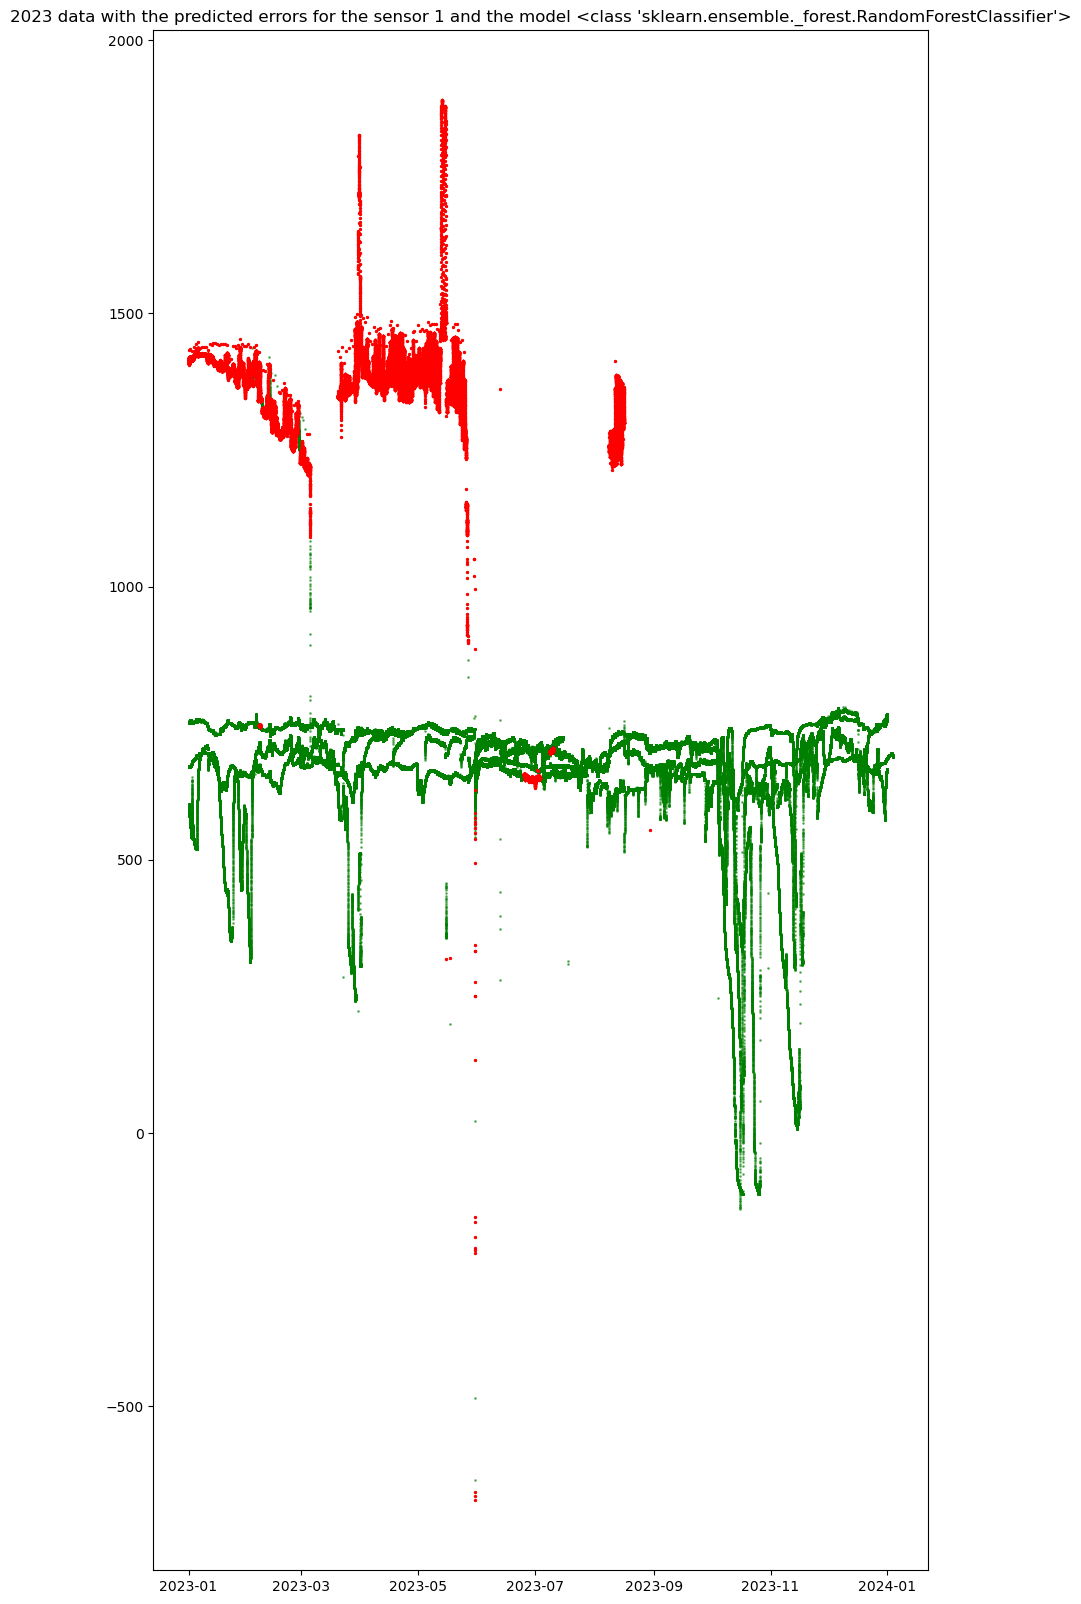

accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 1 is 0.9861406982281146


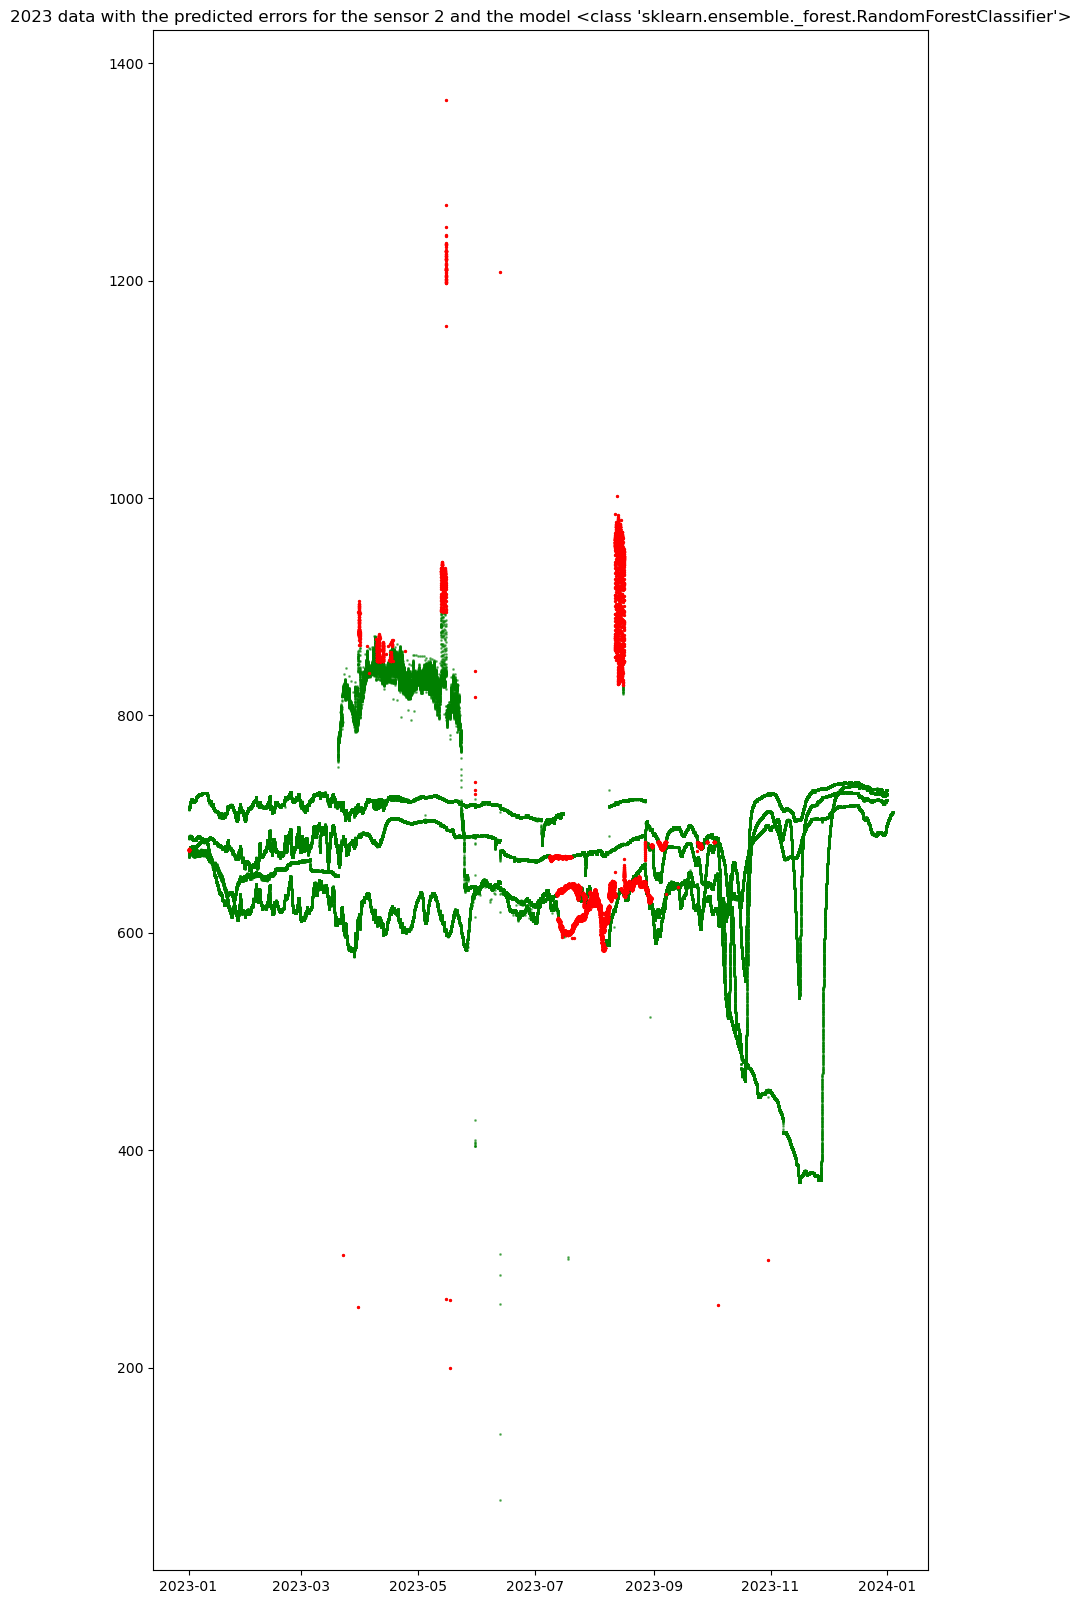

accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 2 is 0.9948873461818


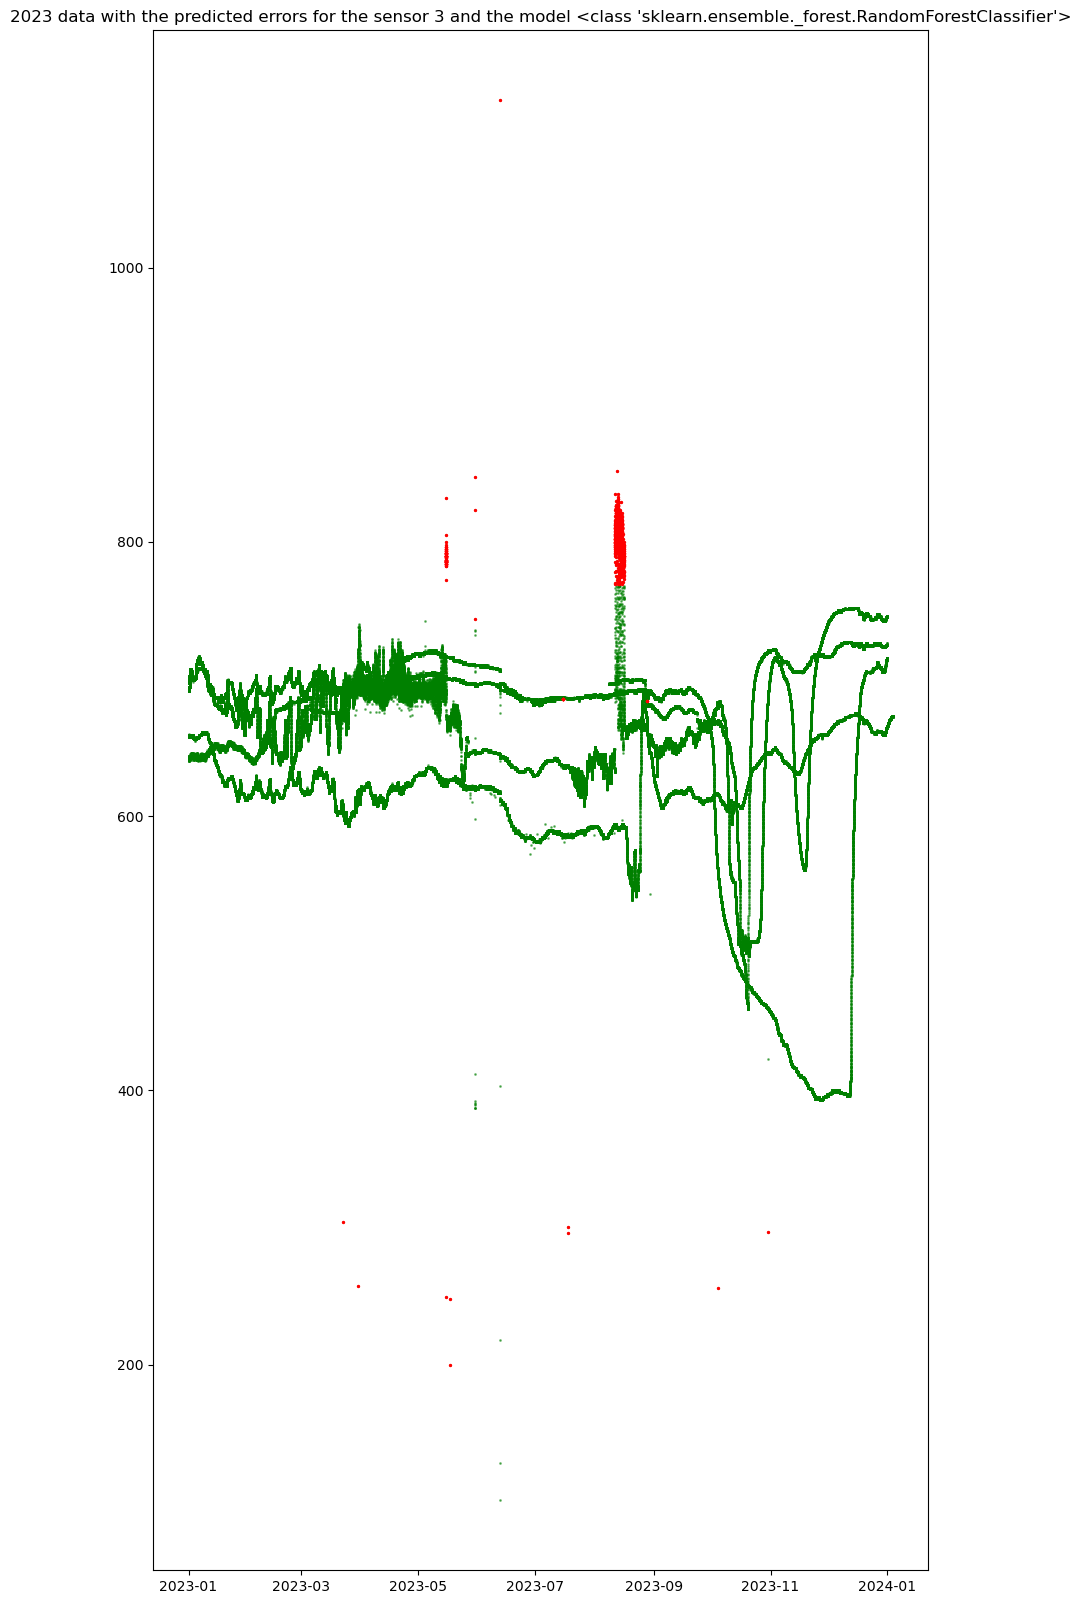

accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 3 is 0.9932332522994411


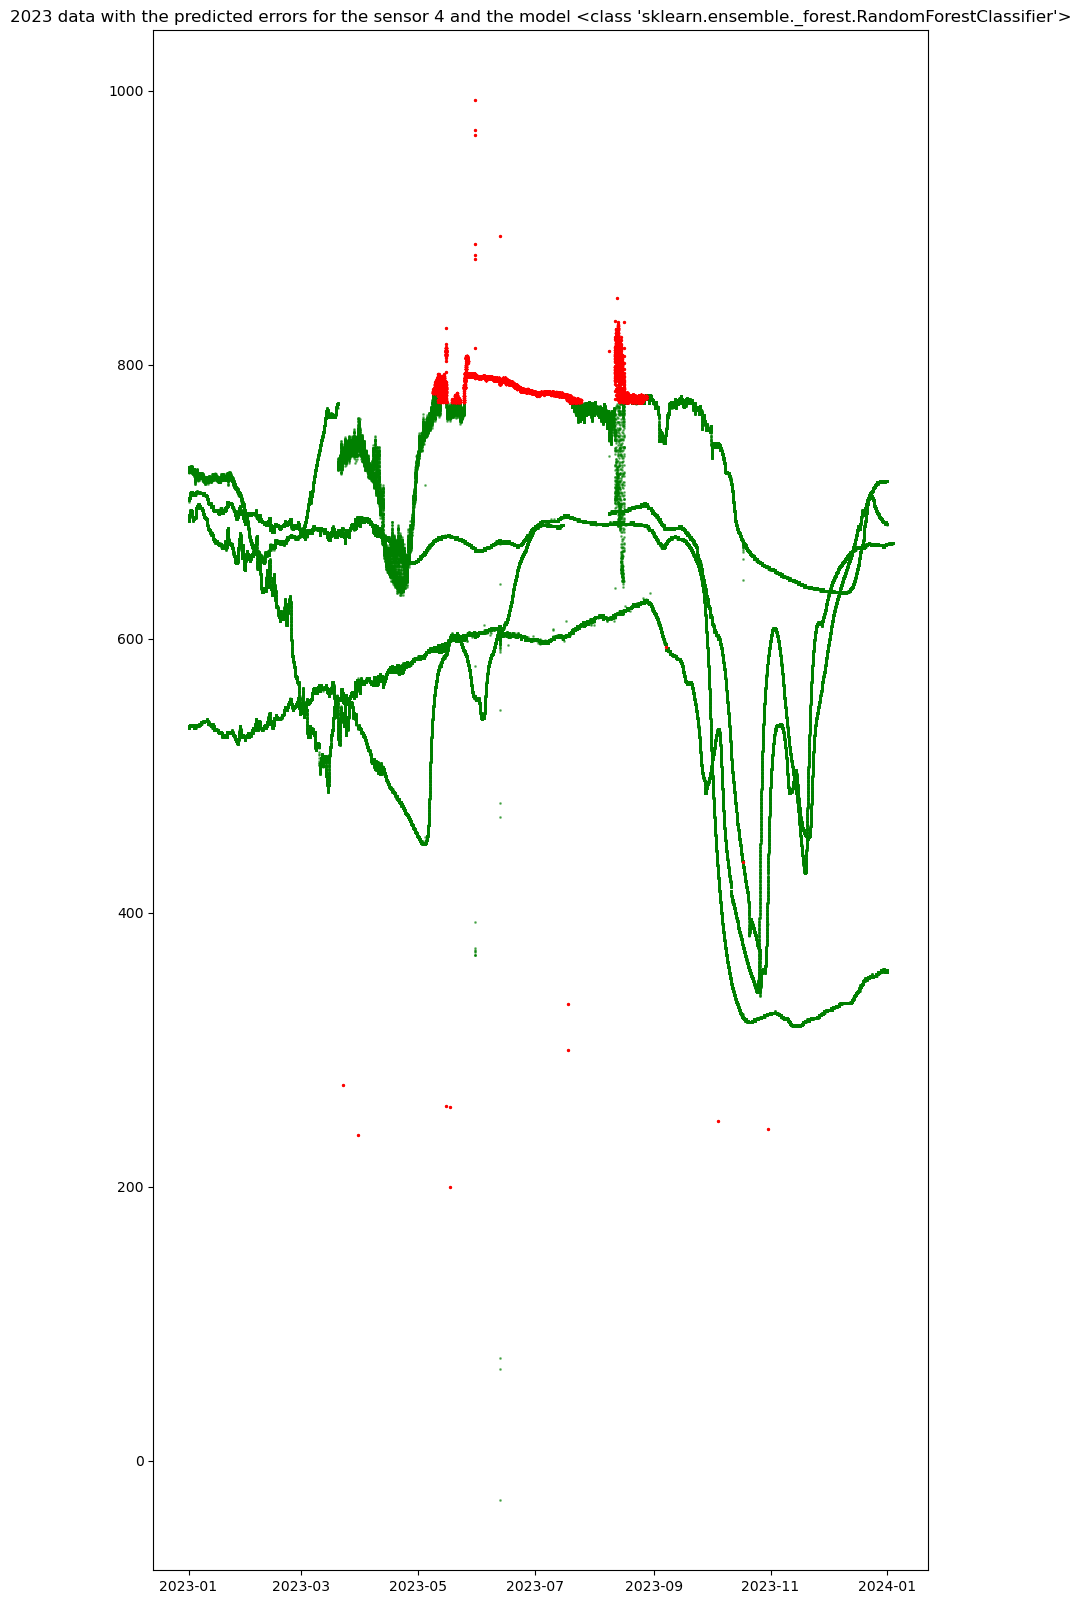

accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 4 is 0.9841607979749881


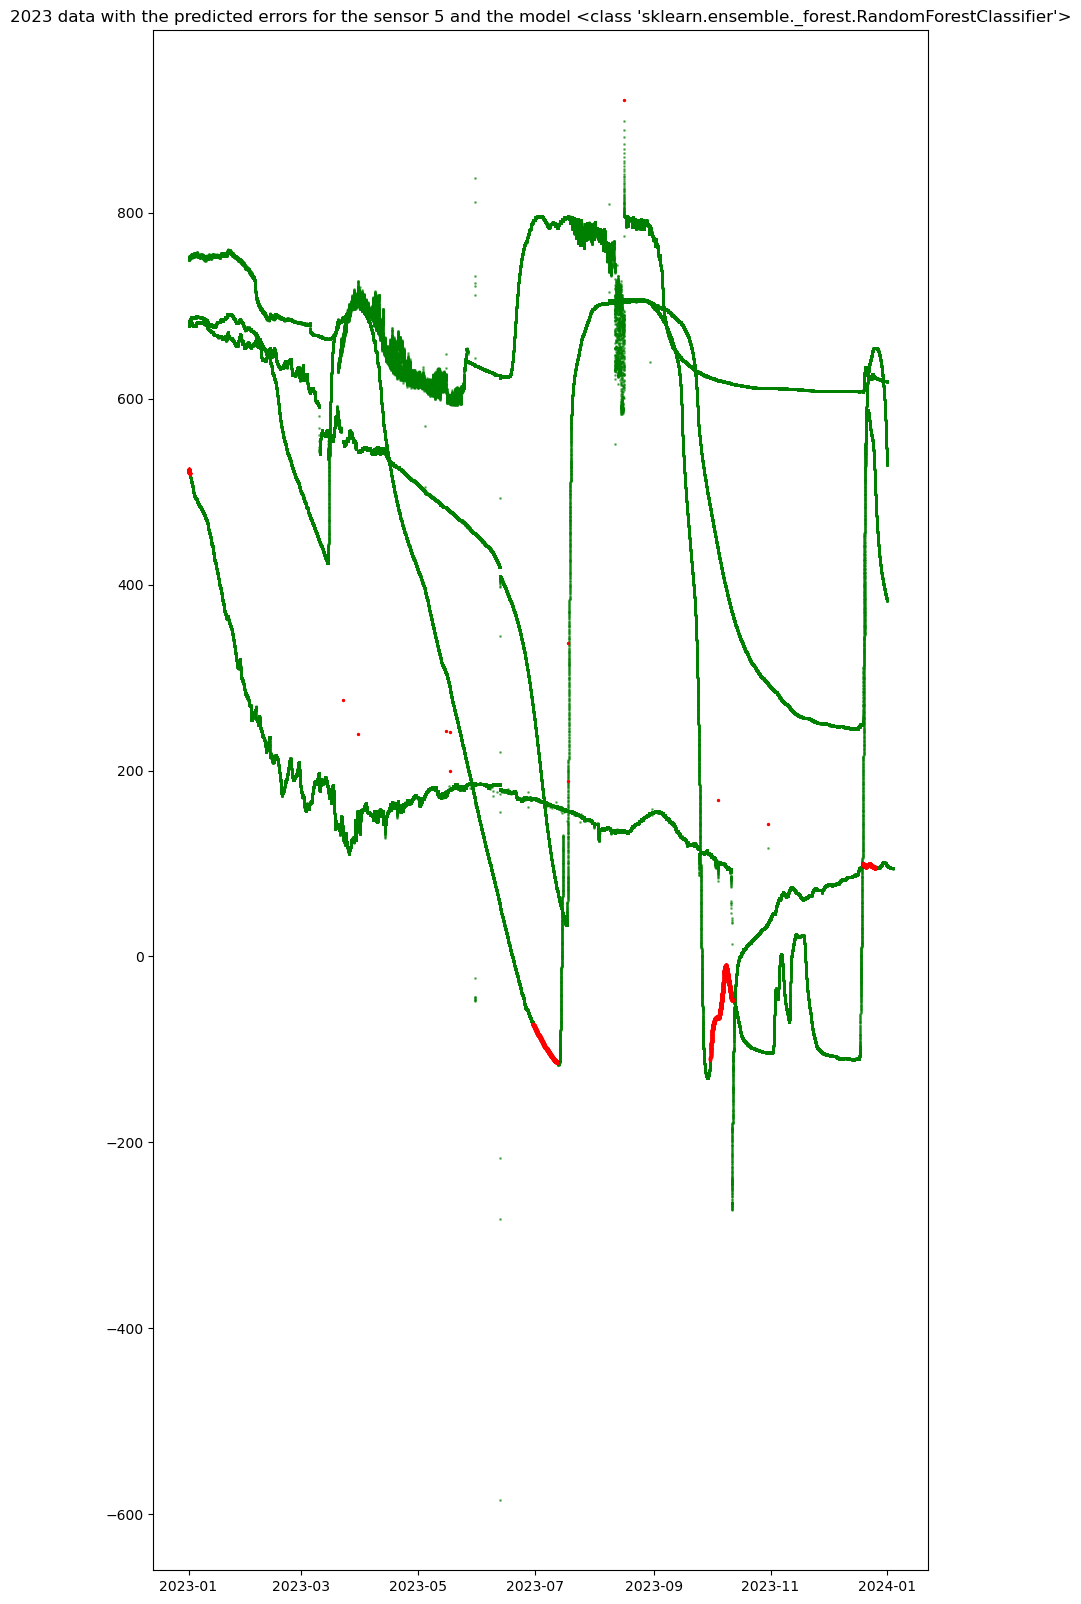

accuracy of the <class 'sklearn.ensemble._forest.RandomForestClassifier'> on the sensor 5 is 0.9977945414901882


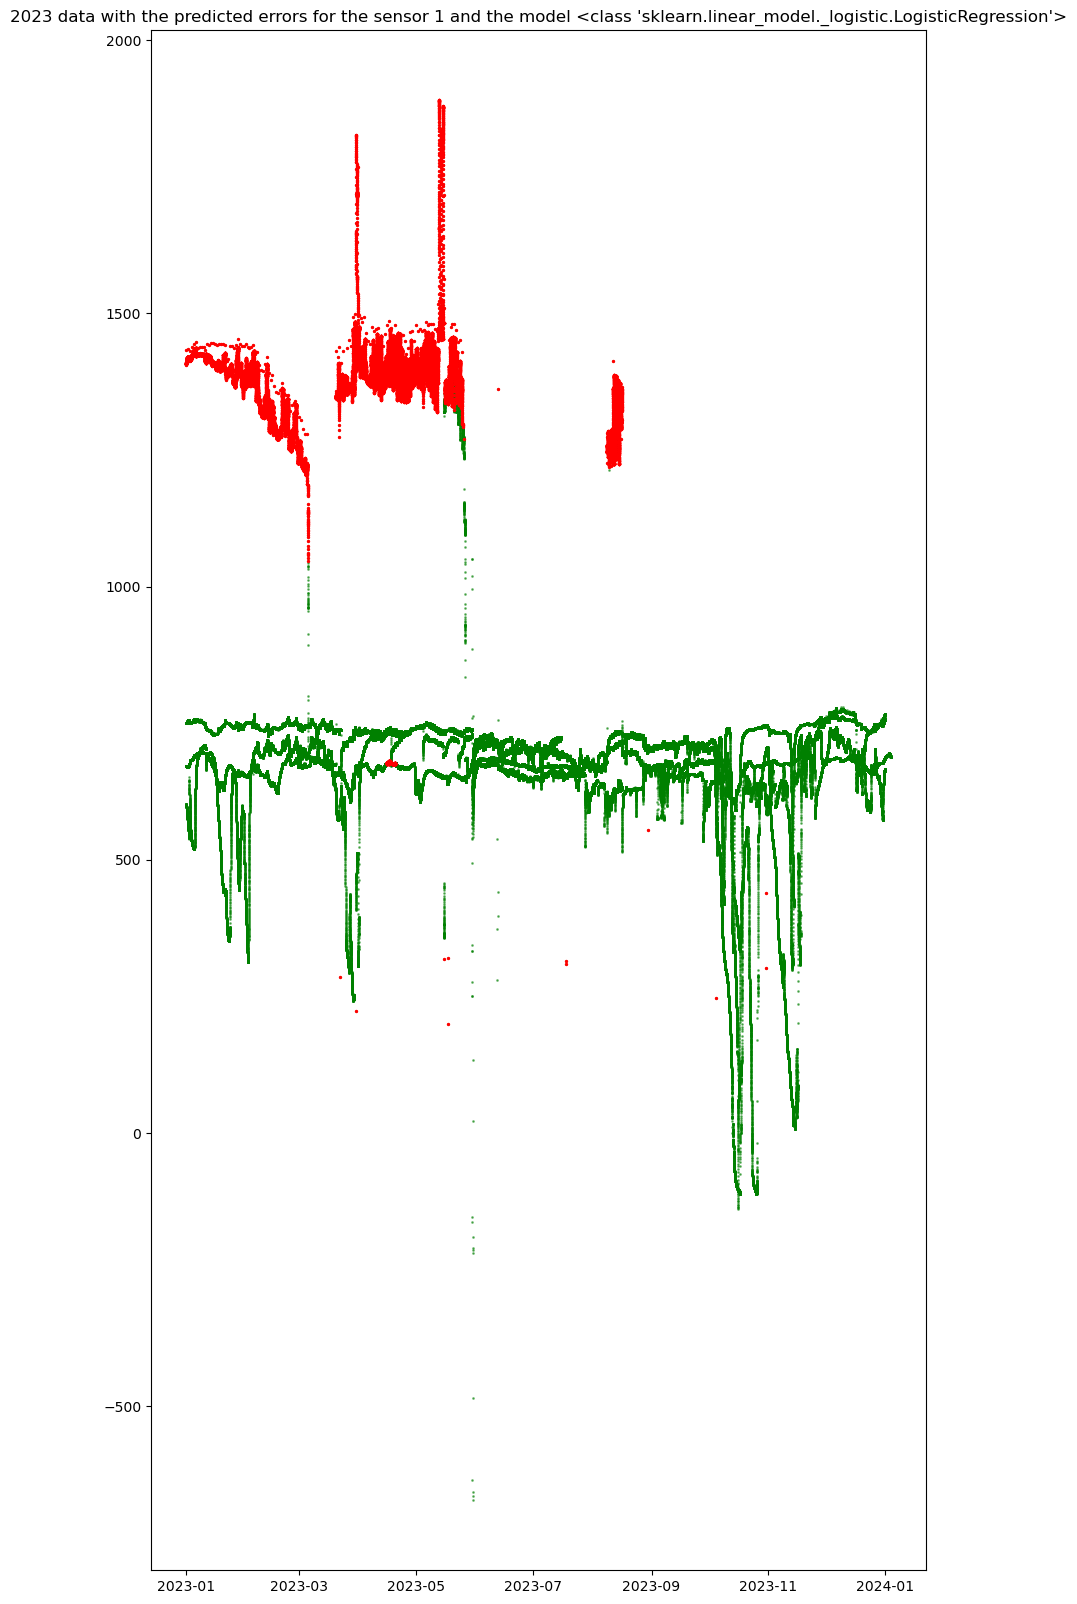

accuracy of the <class 'sklearn.linear_model._logistic.LogisticRegression'> on the sensor 1 is 0.891230796220646


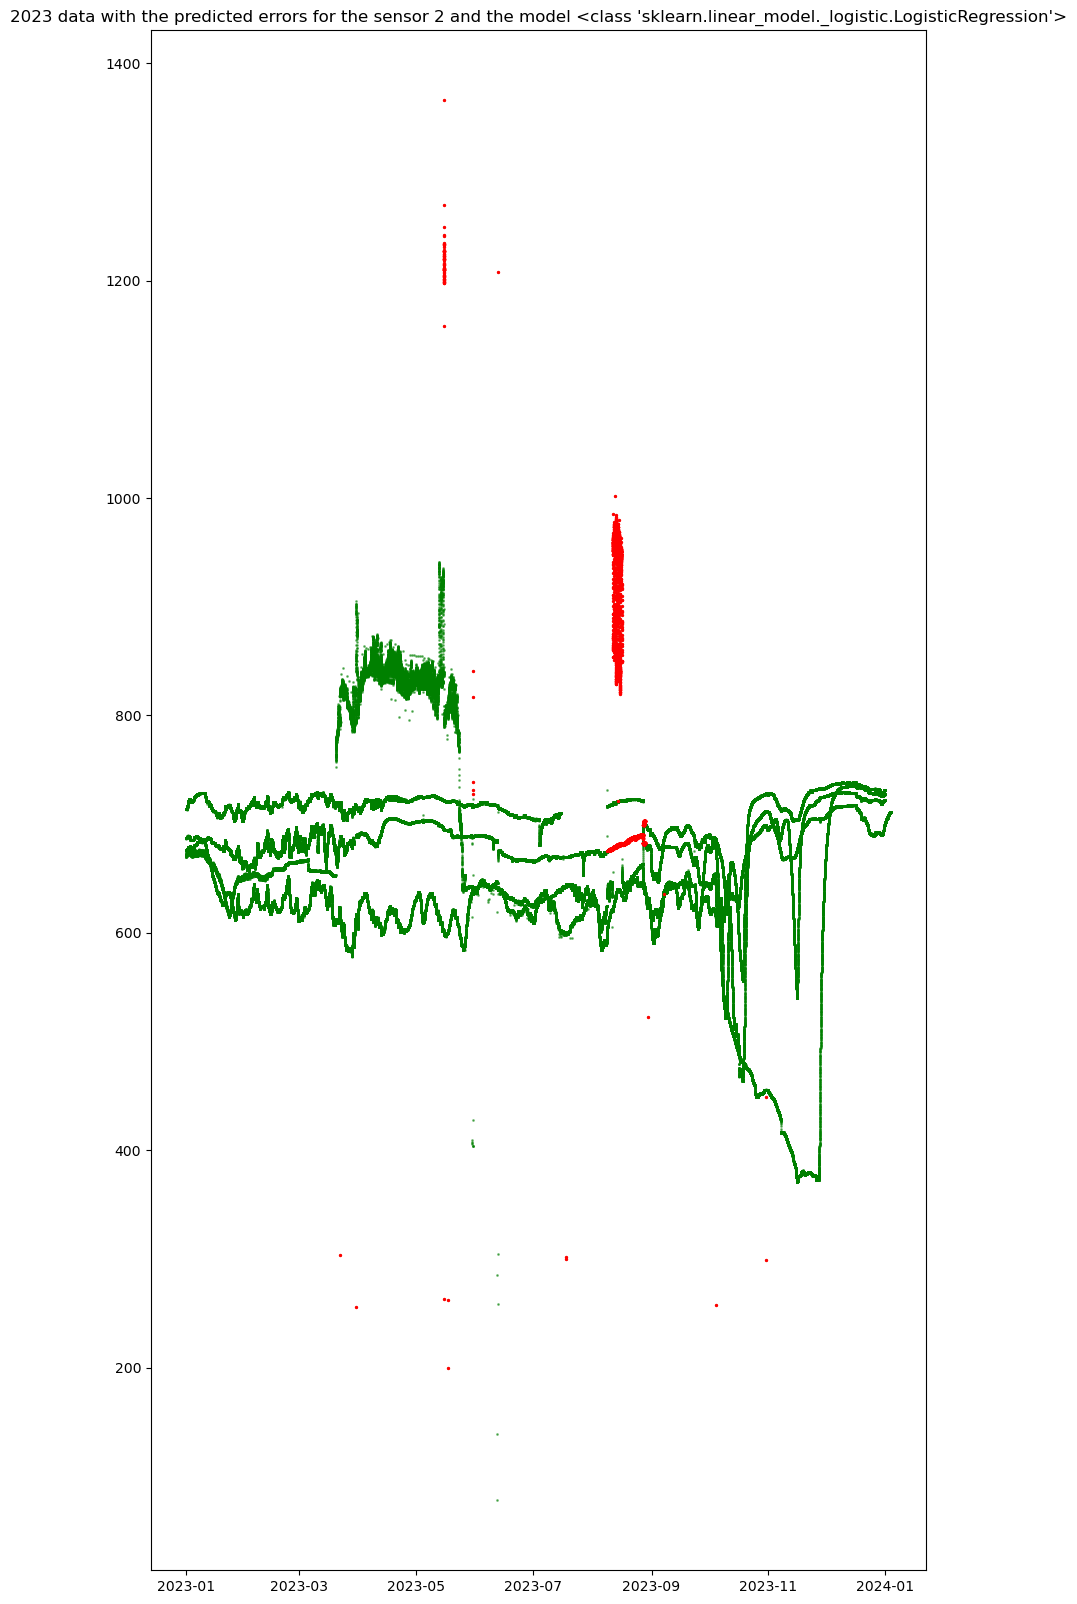

accuracy of the <class 'sklearn.linear_model._logistic.LogisticRegression'> on the sensor 2 is 0.9339615548482494


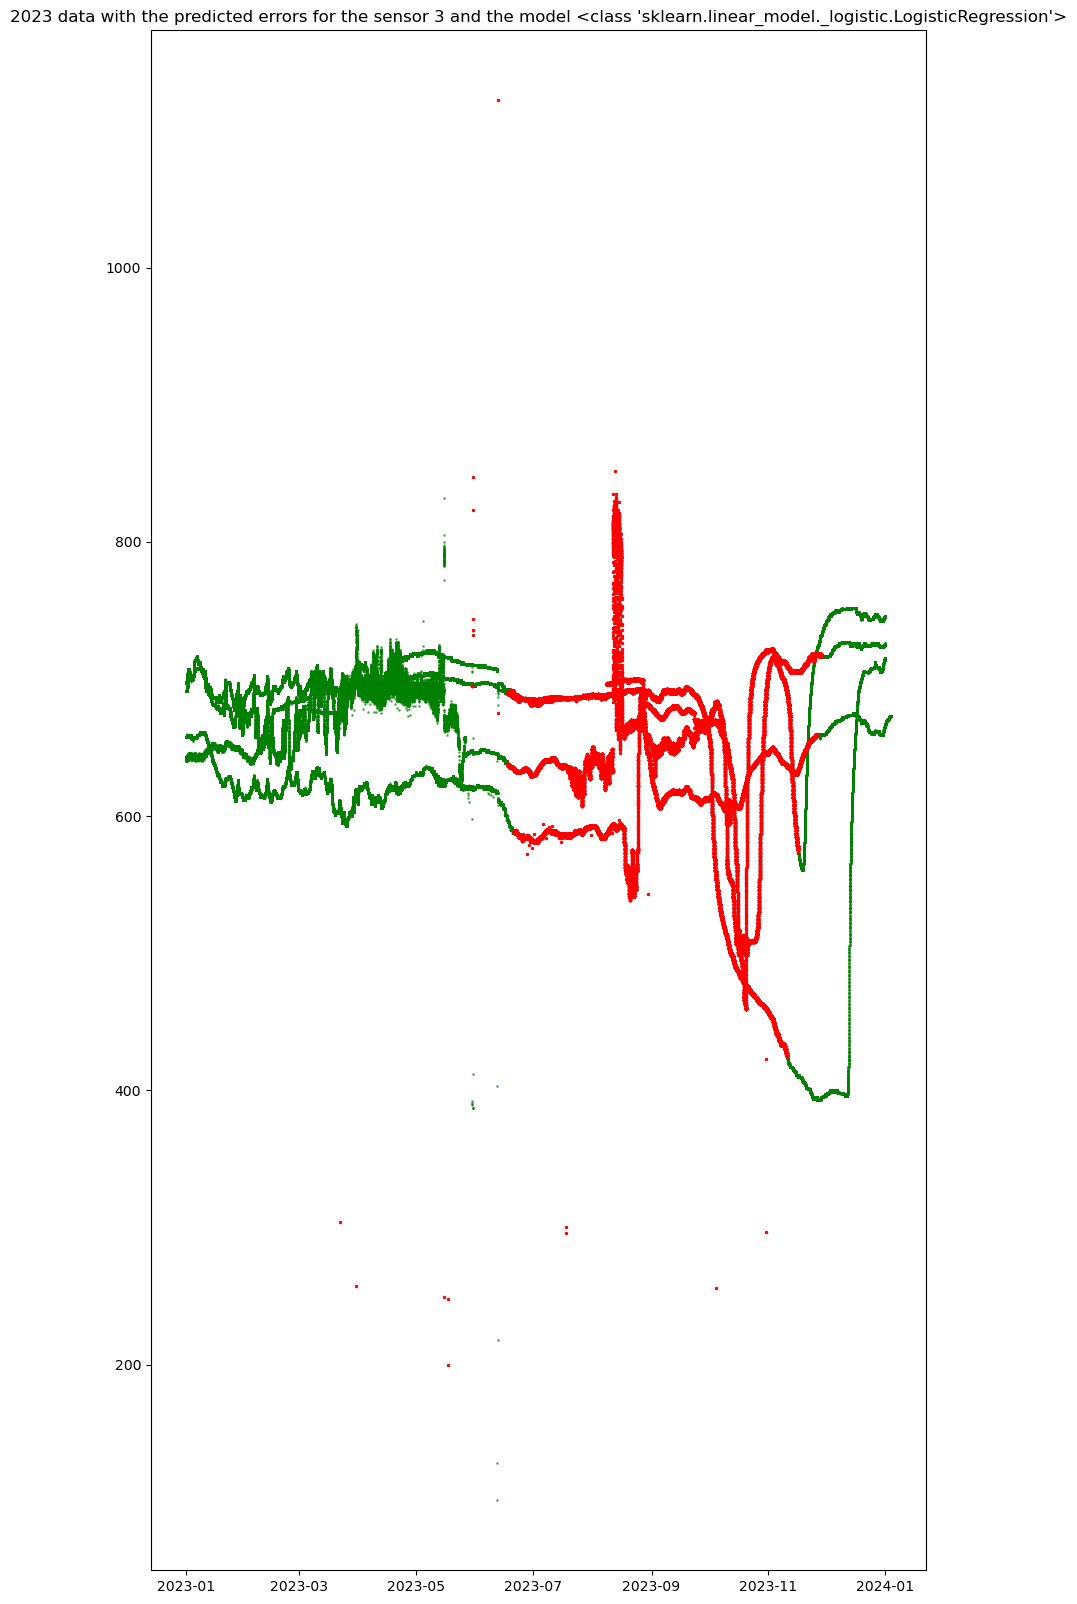

accuracy of the <class 'sklearn.linear_model._logistic.LogisticRegression'> on the sensor 3 is 0.877170998220596


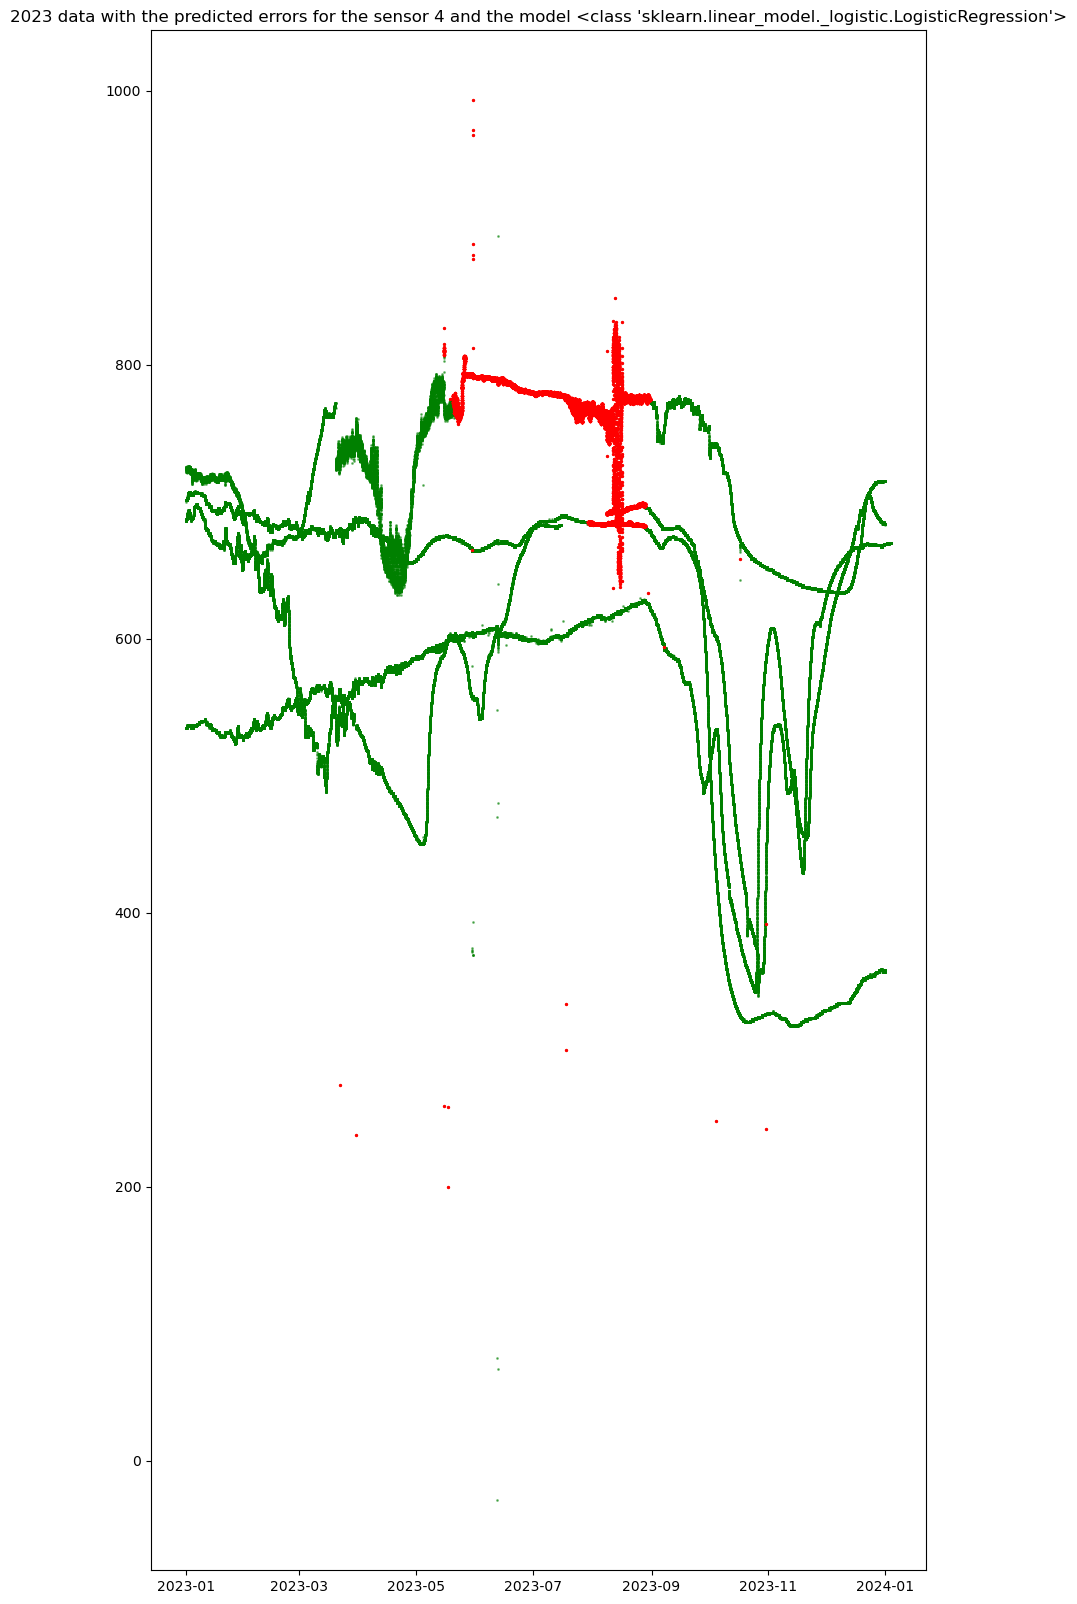

accuracy of the <class 'sklearn.linear_model._logistic.LogisticRegression'> on the sensor 4 is 0.889225833938999


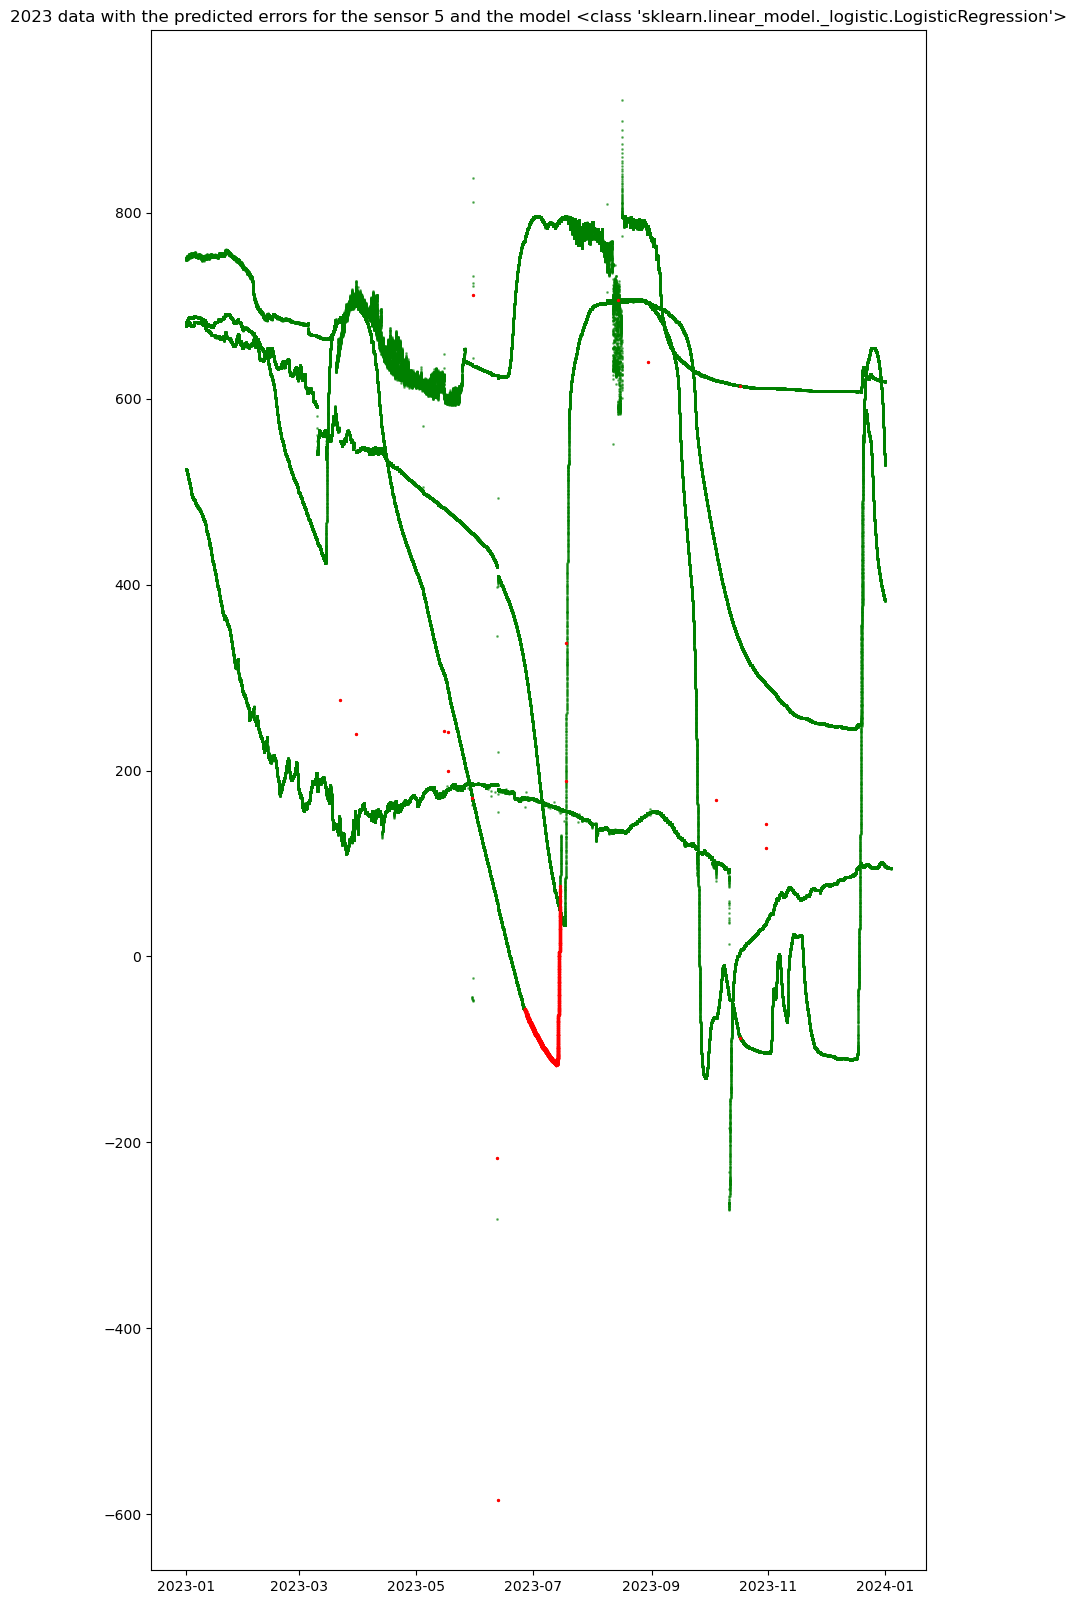

accuracy of the <class 'sklearn.linear_model._logistic.LogisticRegression'> on the sensor 5 is 0.8924337735896344


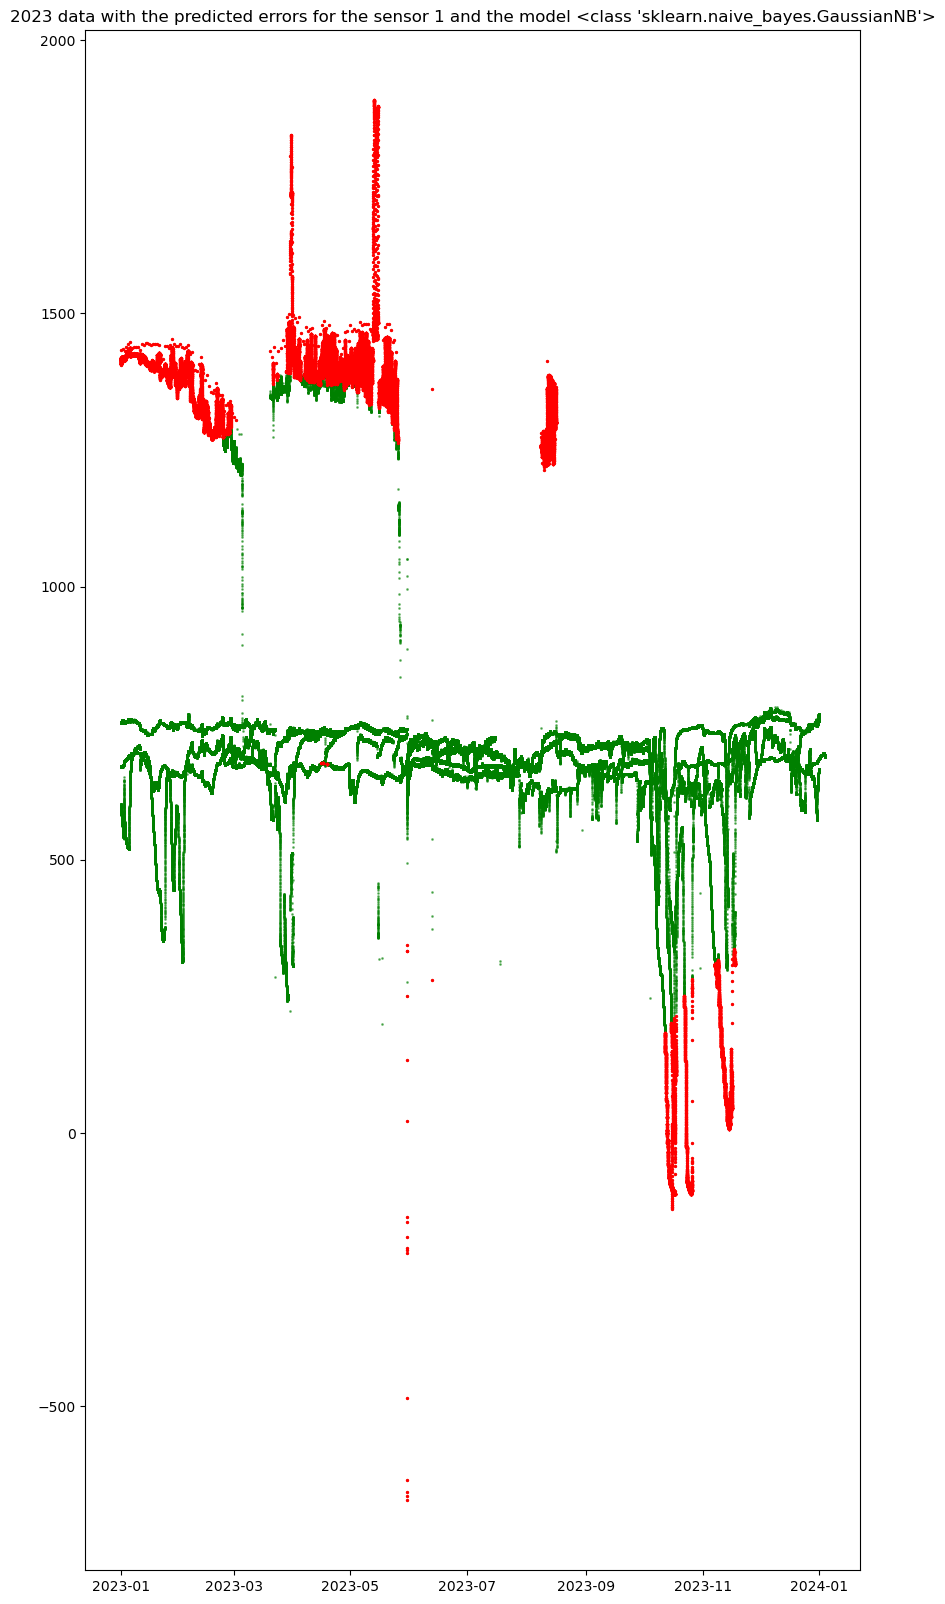

accuracy of the <class 'sklearn.naive_bayes.GaussianNB'> on the sensor 1 is 0.9557153956041202


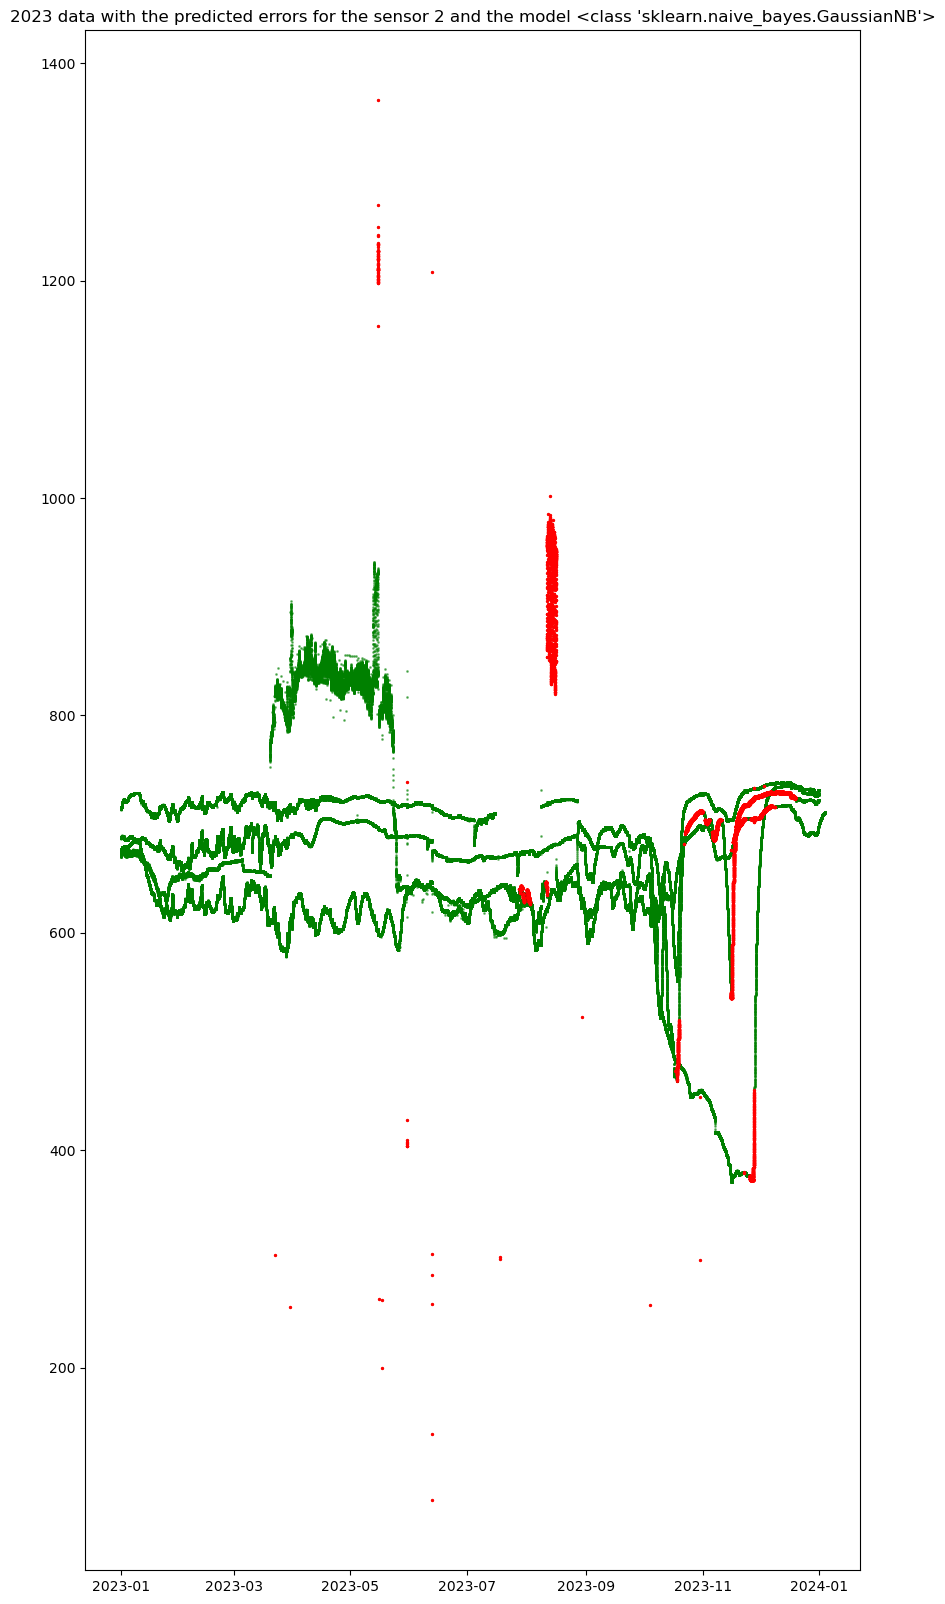

accuracy of the <class 'sklearn.naive_bayes.GaussianNB'> on the sensor 2 is 0.9539109295506378


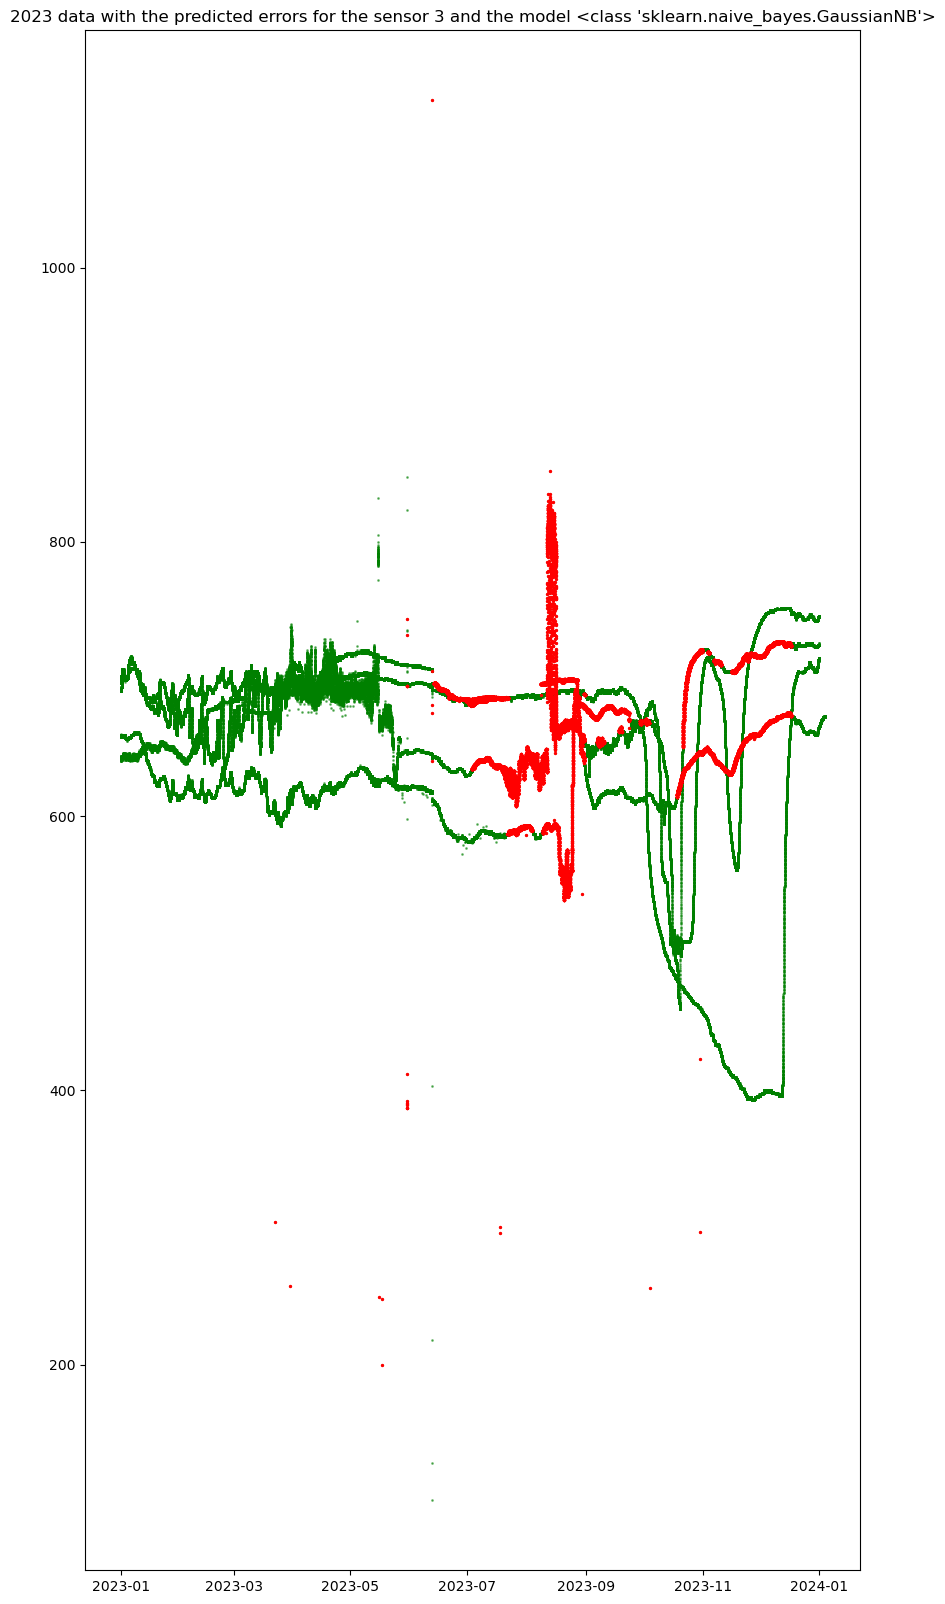

accuracy of the <class 'sklearn.naive_bayes.GaussianNB'> on the sensor 3 is 0.7922608455928423


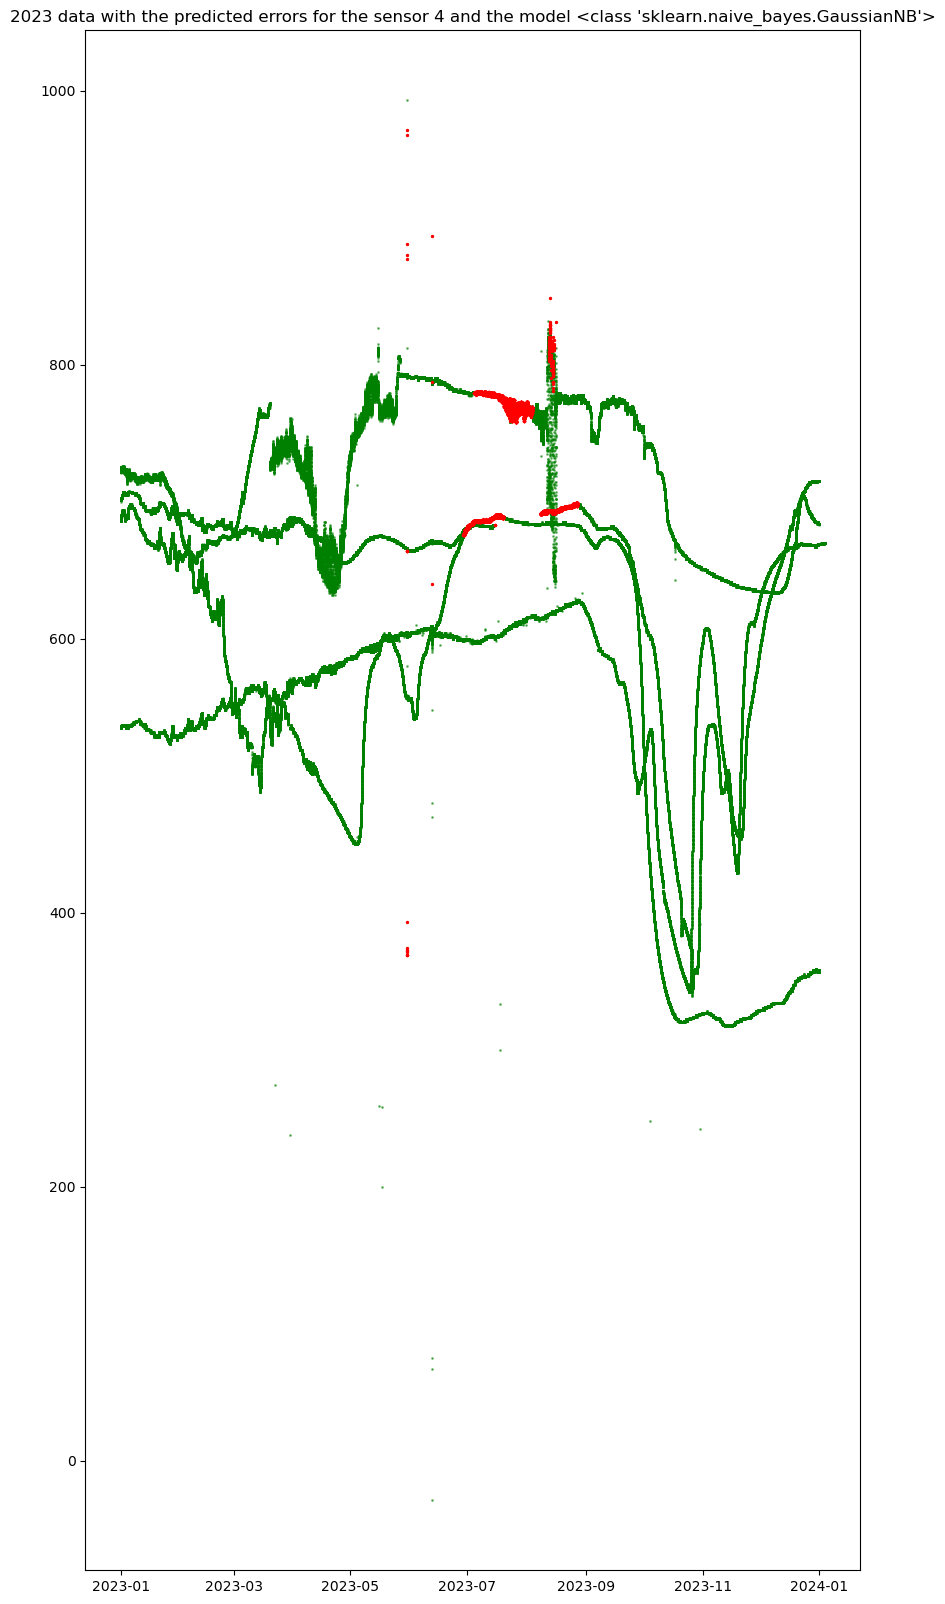

accuracy of the <class 'sklearn.naive_bayes.GaussianNB'> on the sensor 4 is 0.8158943384877572


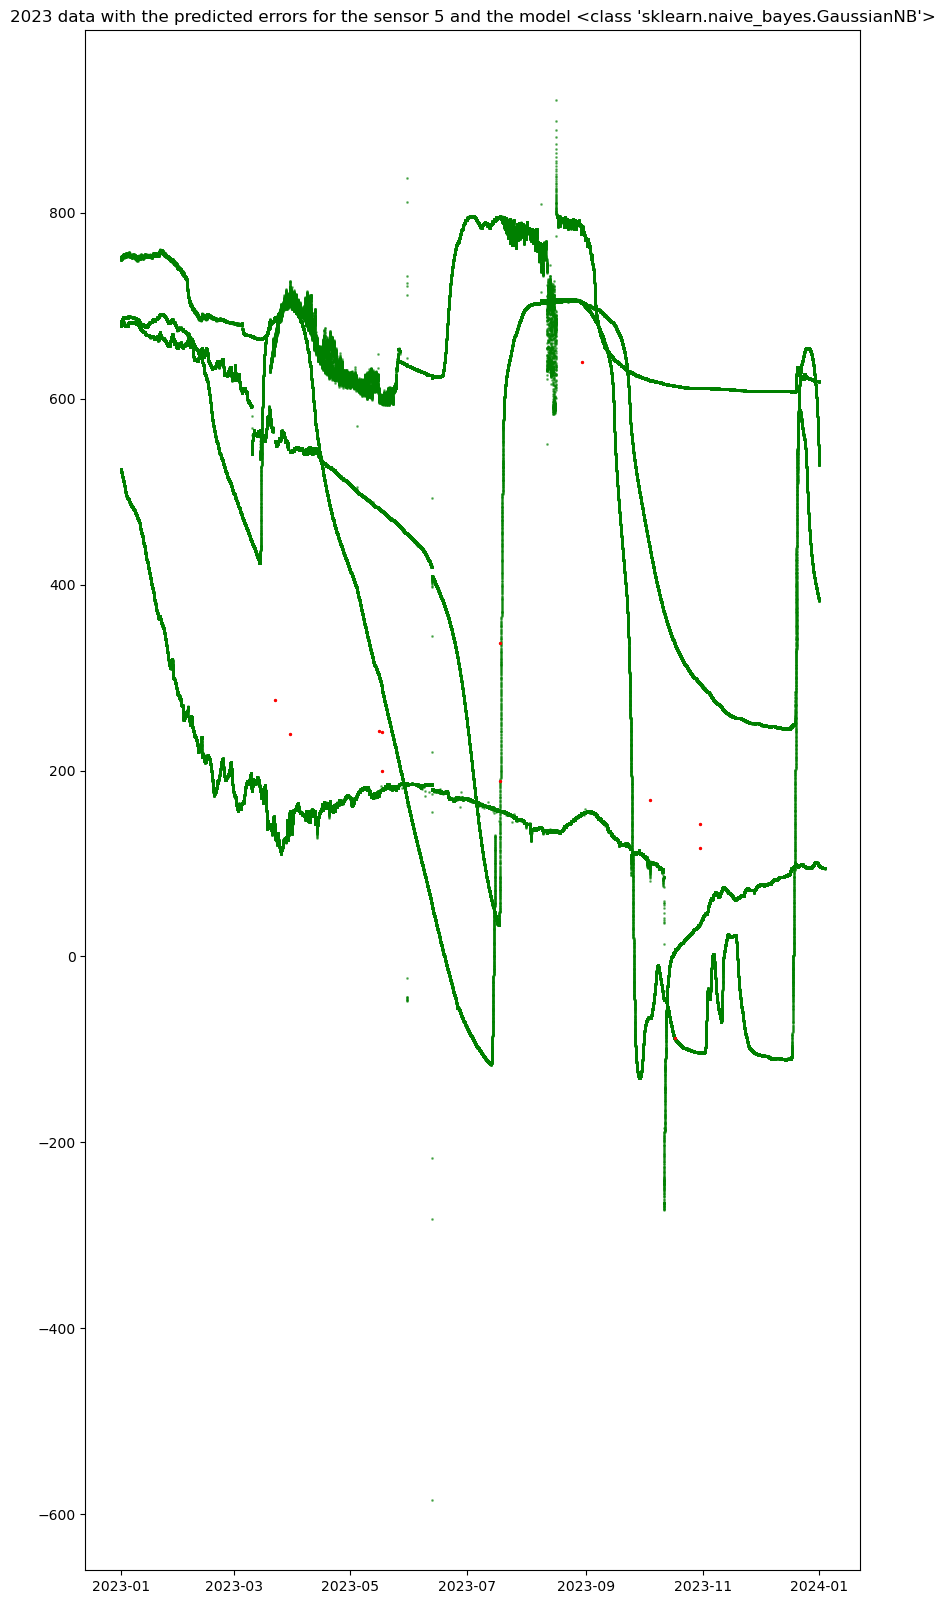

accuracy of the <class 'sklearn.naive_bayes.GaussianNB'> on the sensor 5 is 0.7948672965589835


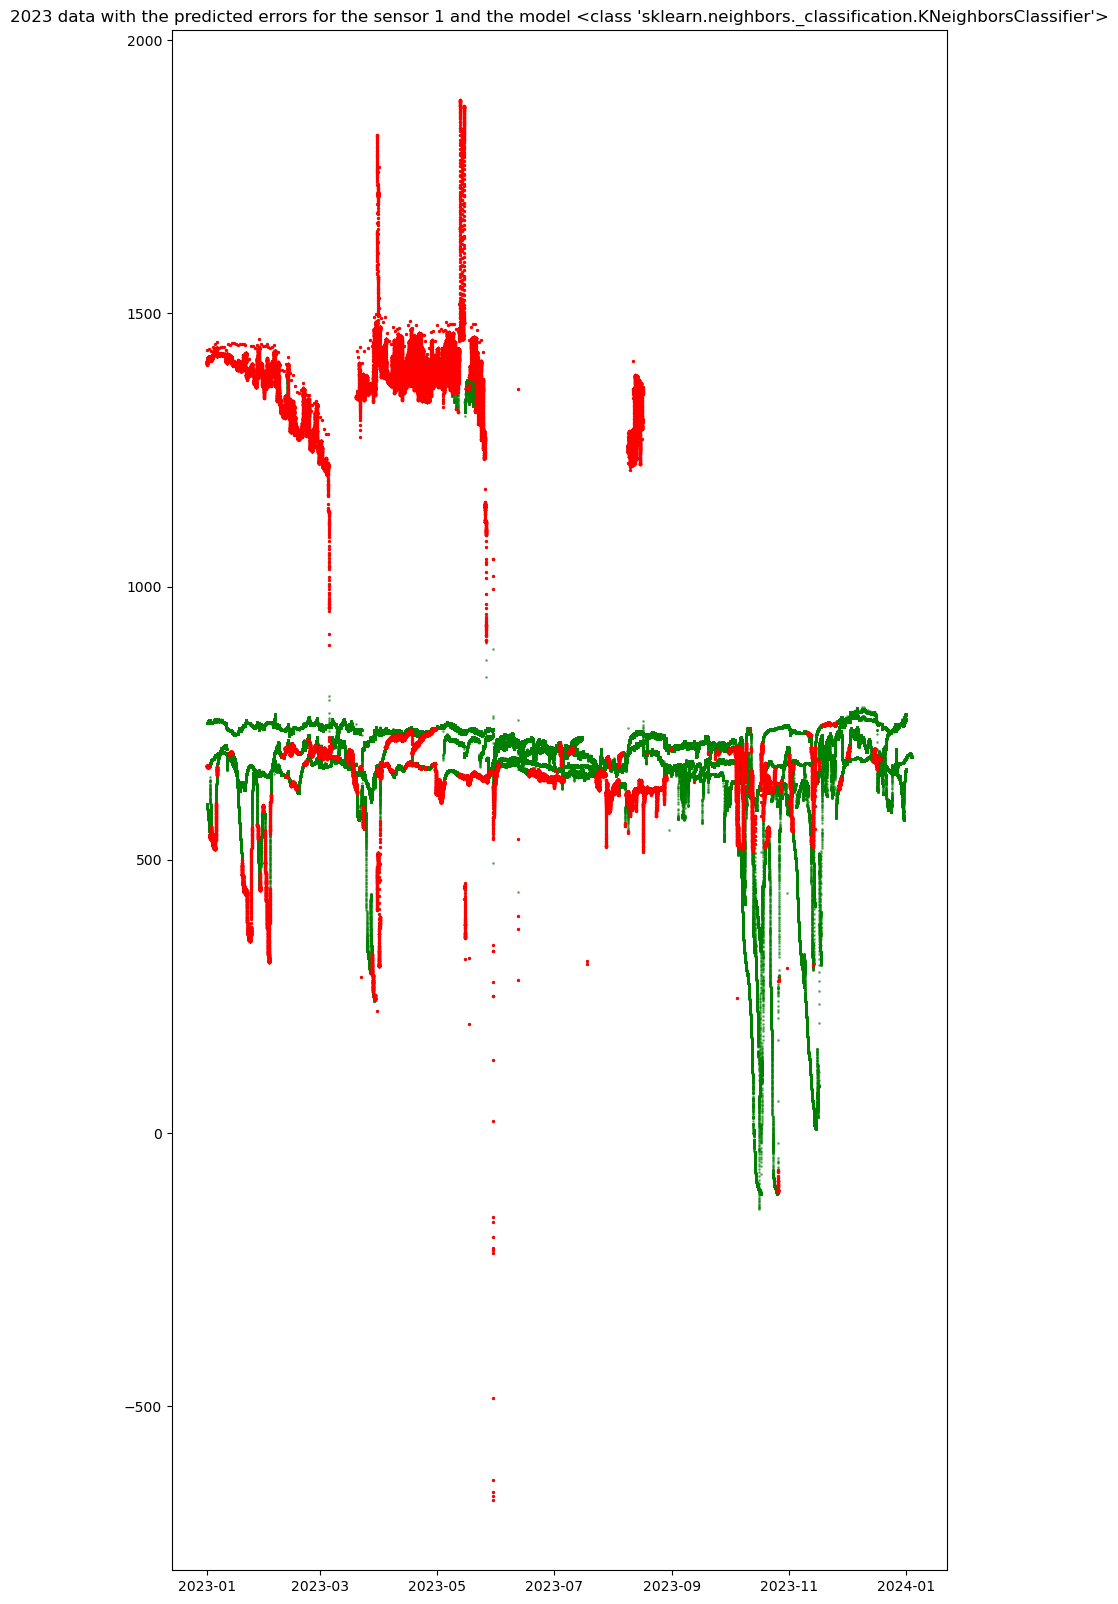

accuracy of the <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on the sensor 1 is 0.9990727049447382


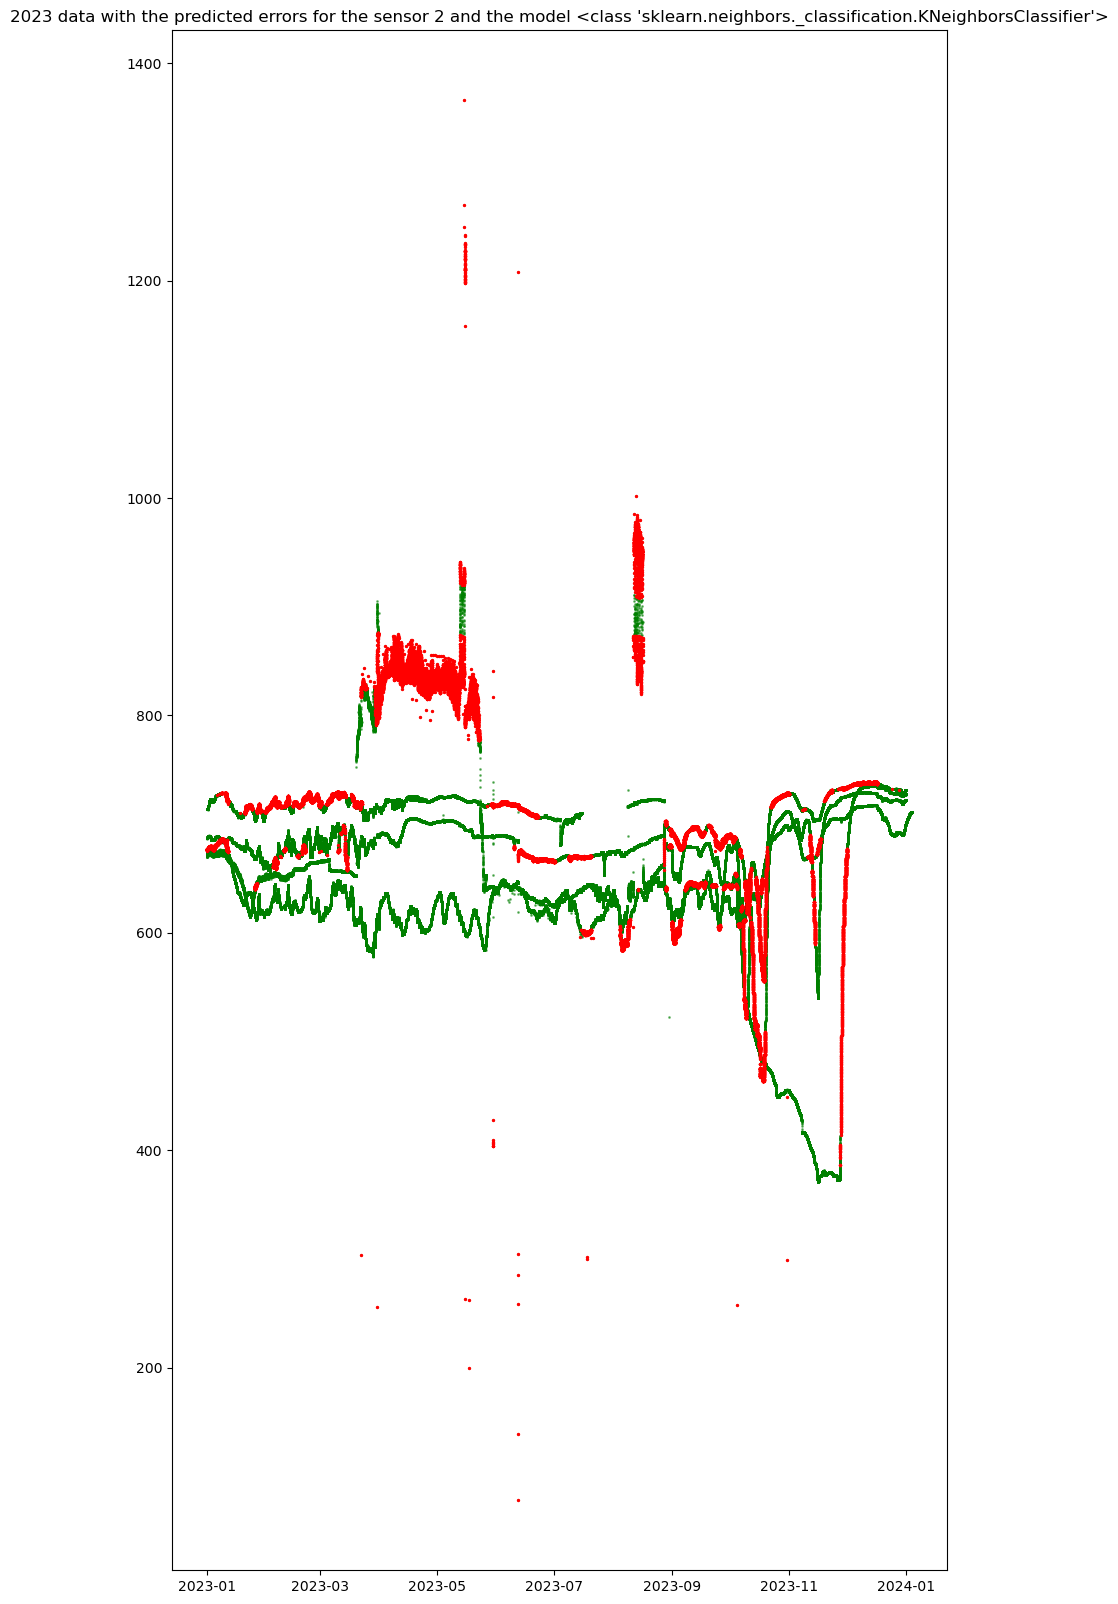

accuracy of the <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on the sensor 2 is 0.999273201172903


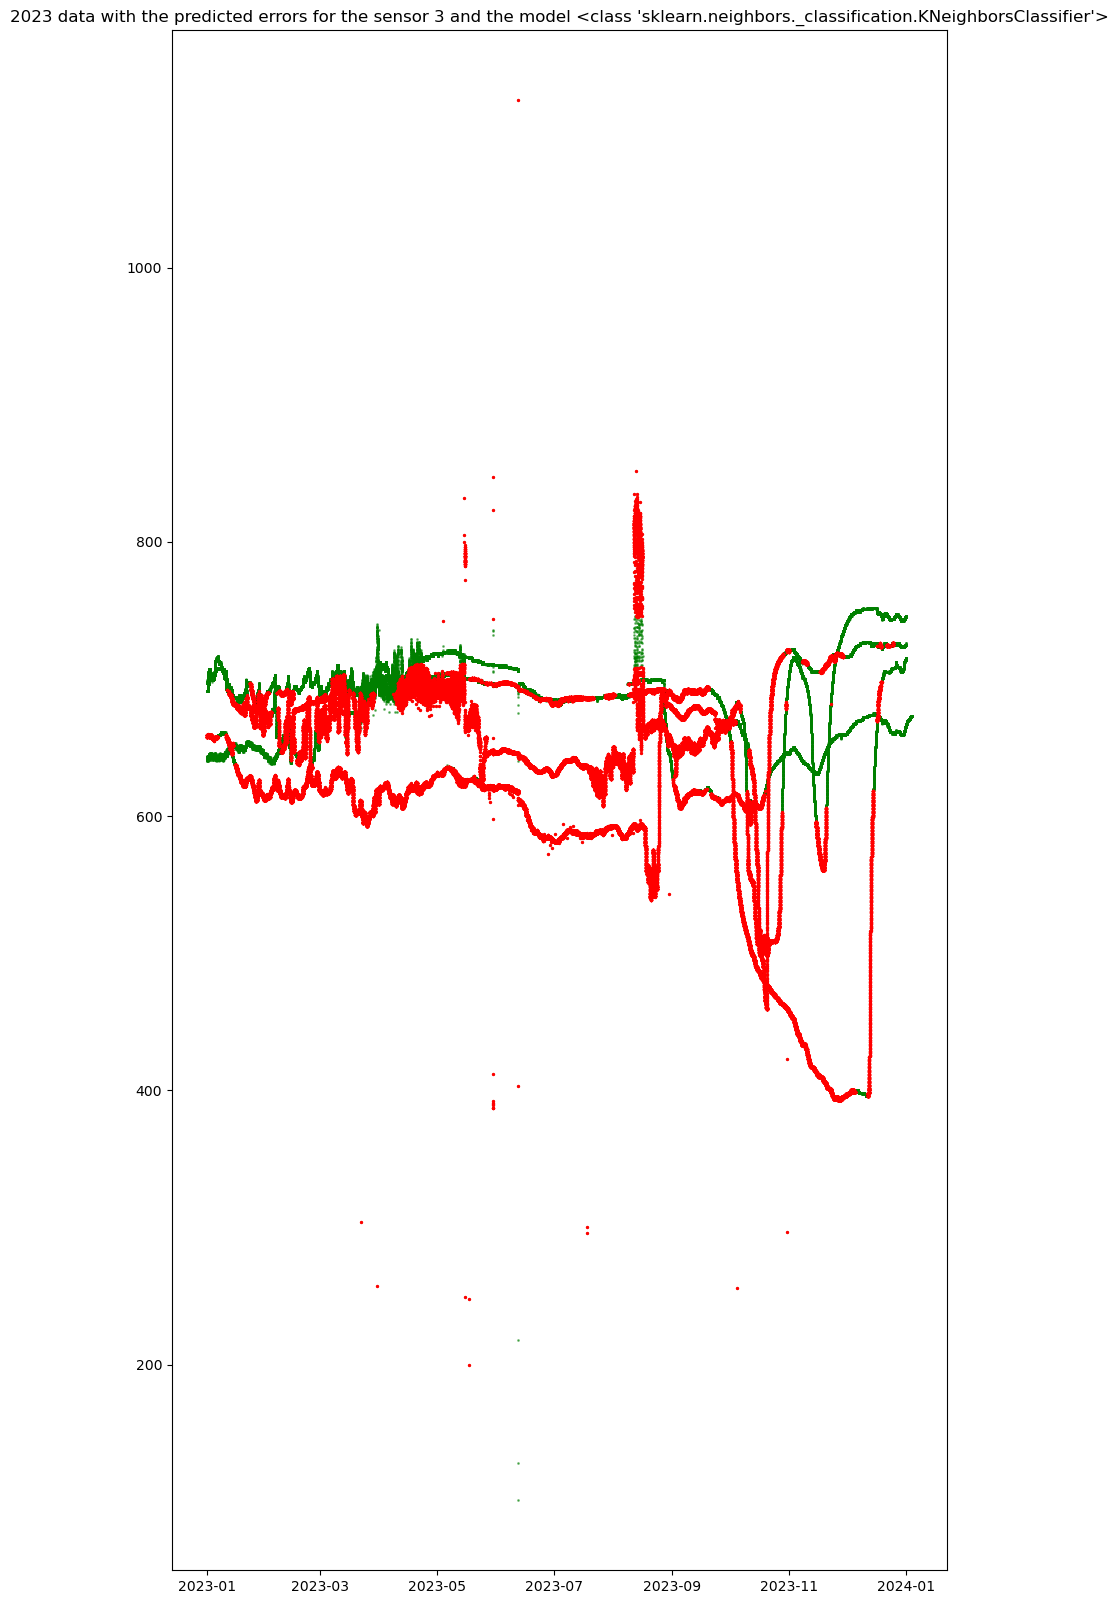

accuracy of the <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on the sensor 3 is 0.9986215884313676


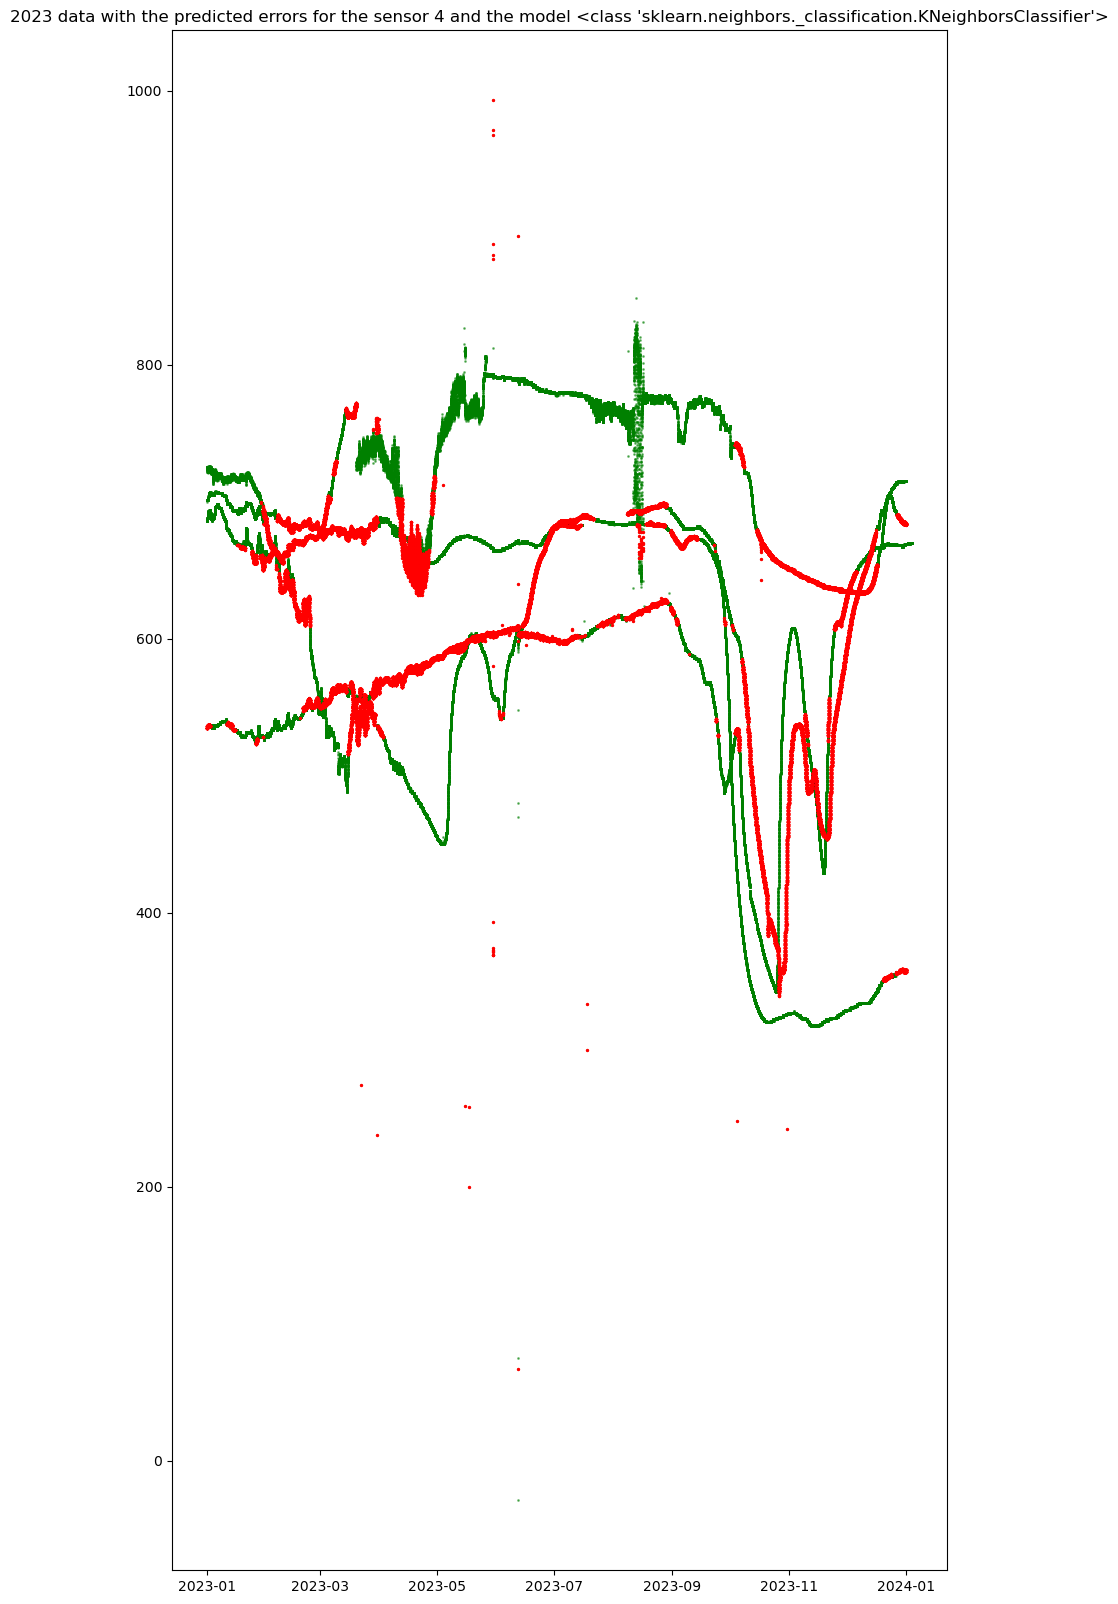

accuracy of the <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on the sensor 4 is 0.9993734492869852


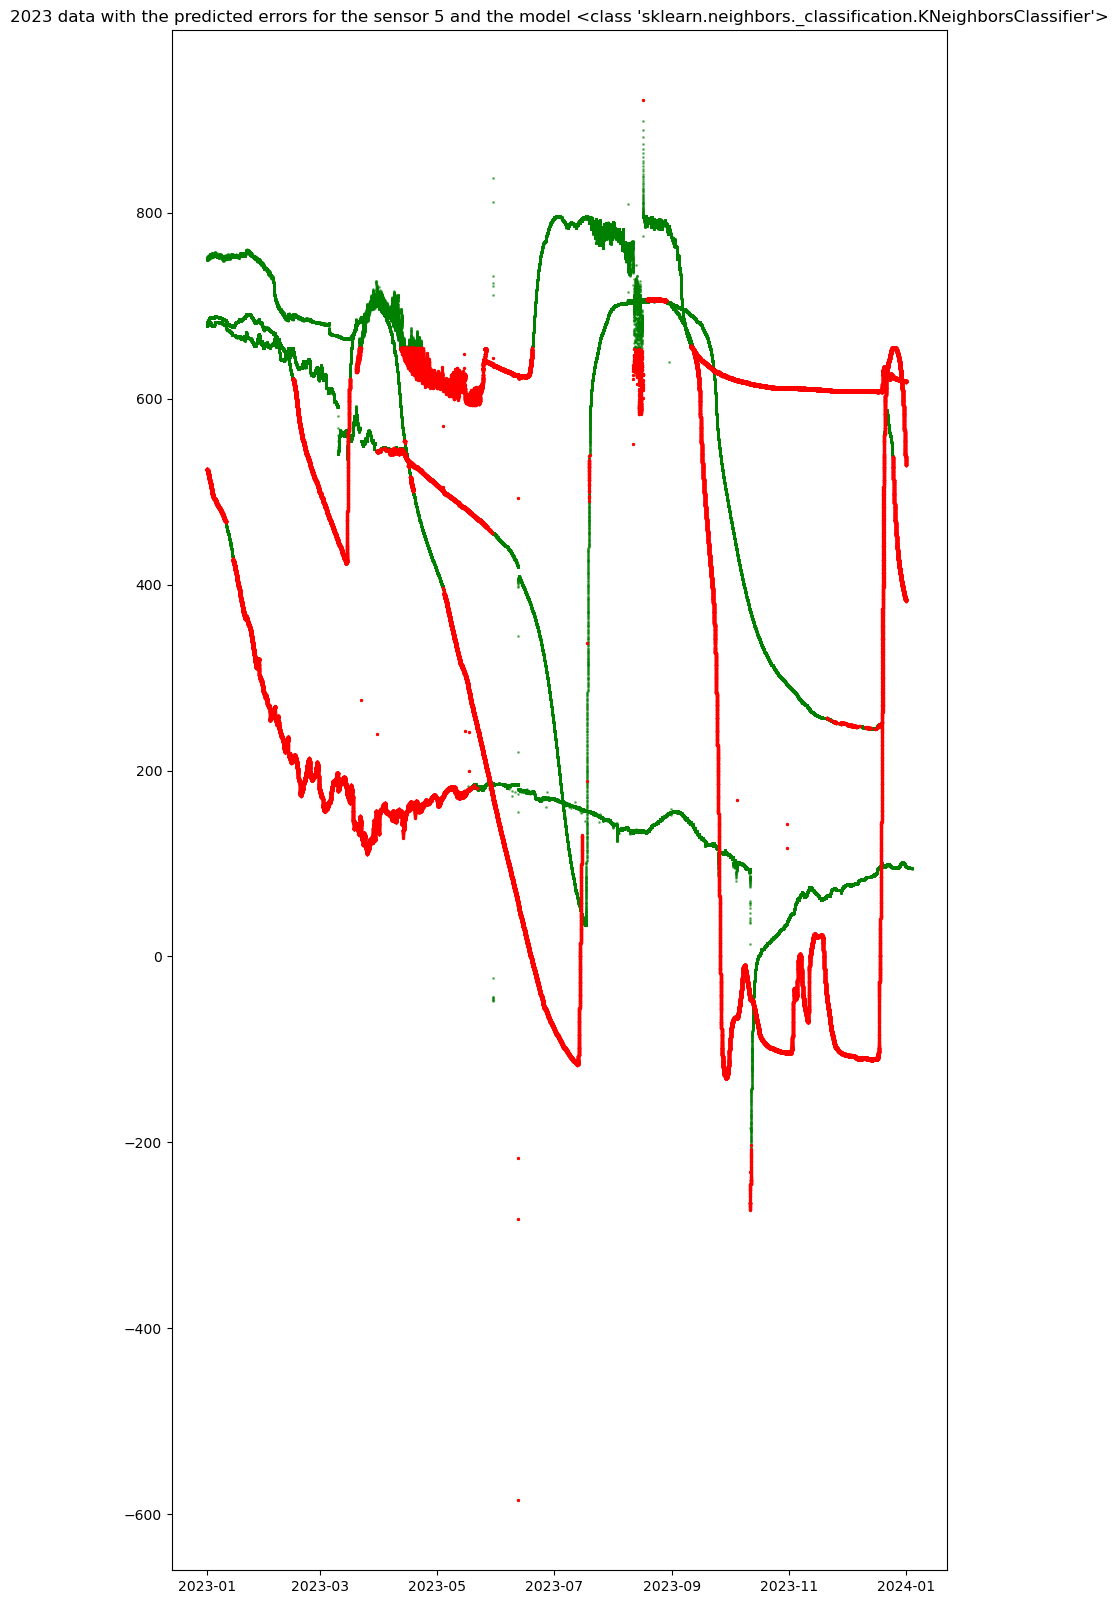

accuracy of the <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on the sensor 5 is 0.9986466504598882


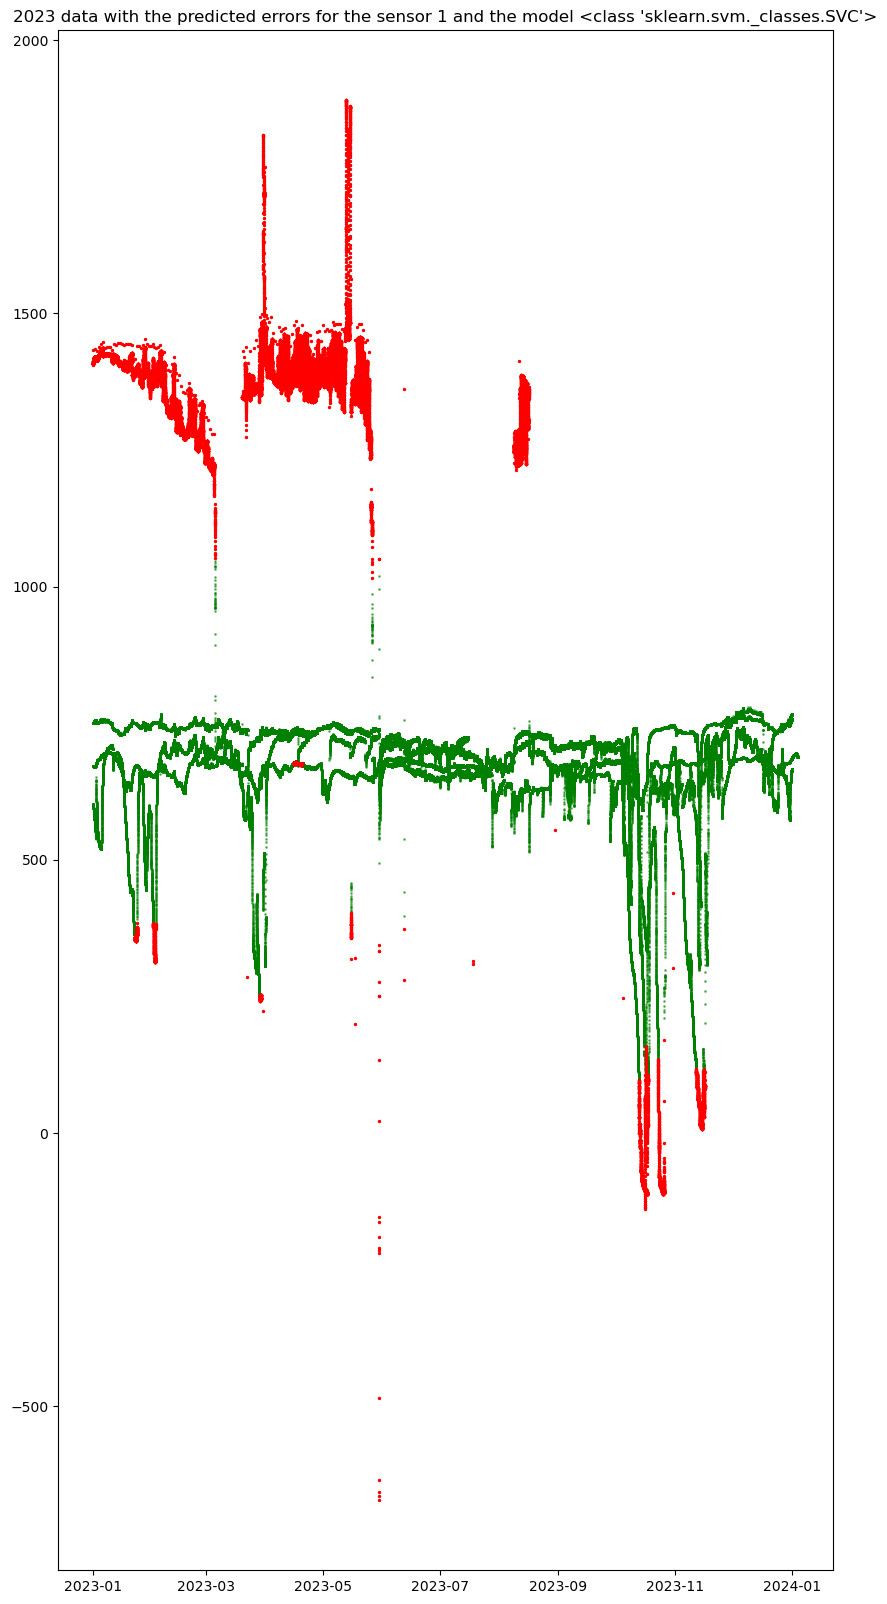

accuracy of the <class 'sklearn.svm._classes.SVC'> on the sensor 1 is 0.958647652941029


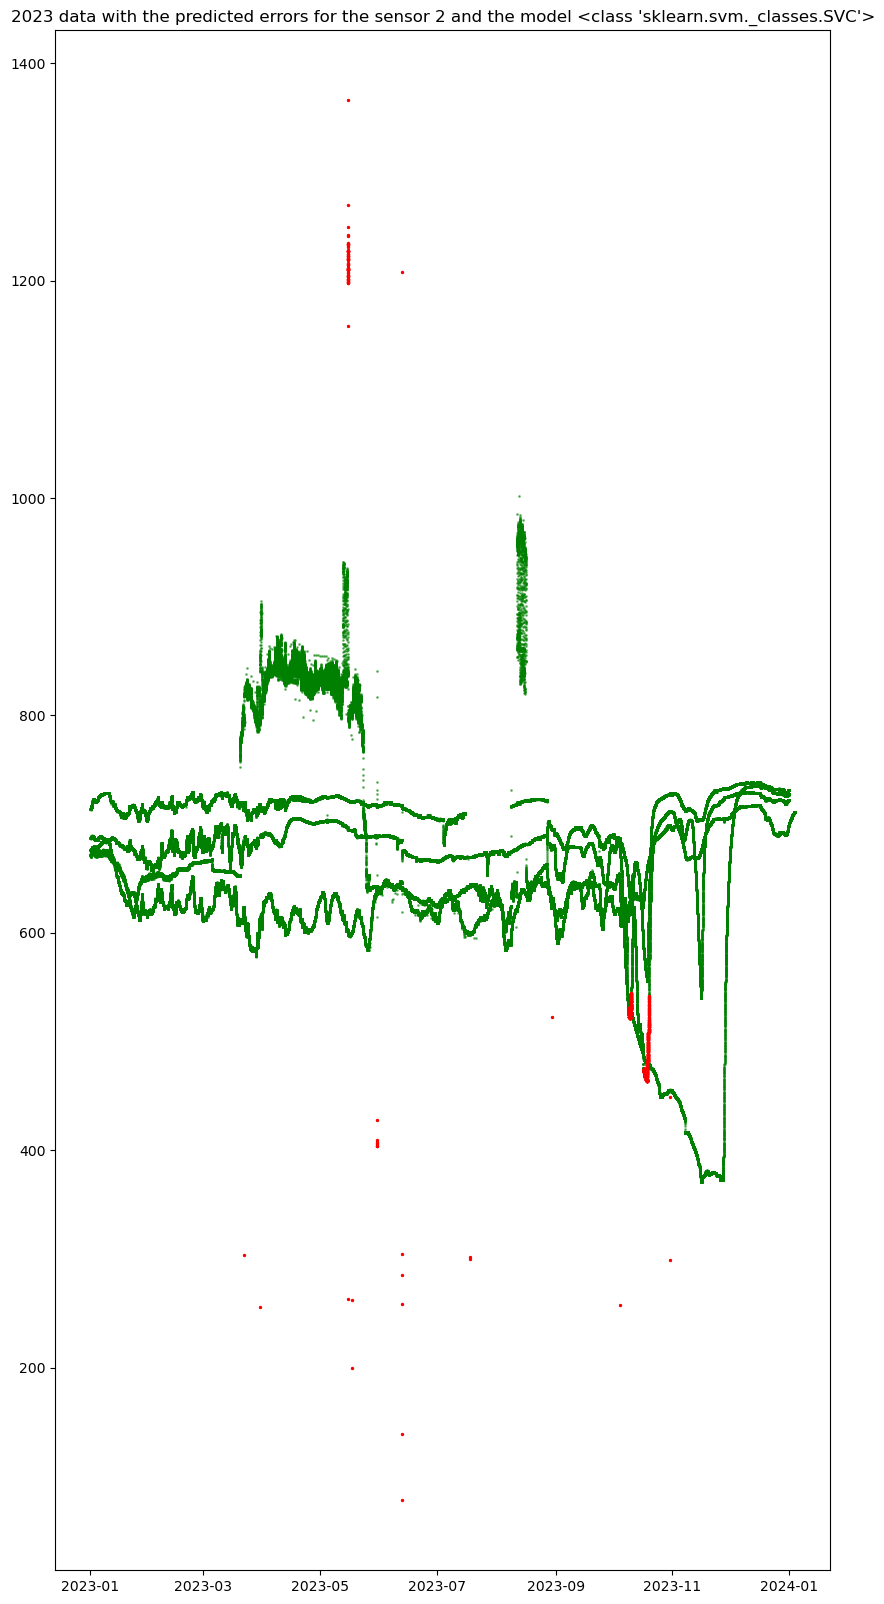

accuracy of the <class 'sklearn.svm._classes.SVC'> on the sensor 2 is 0.9549885967770231


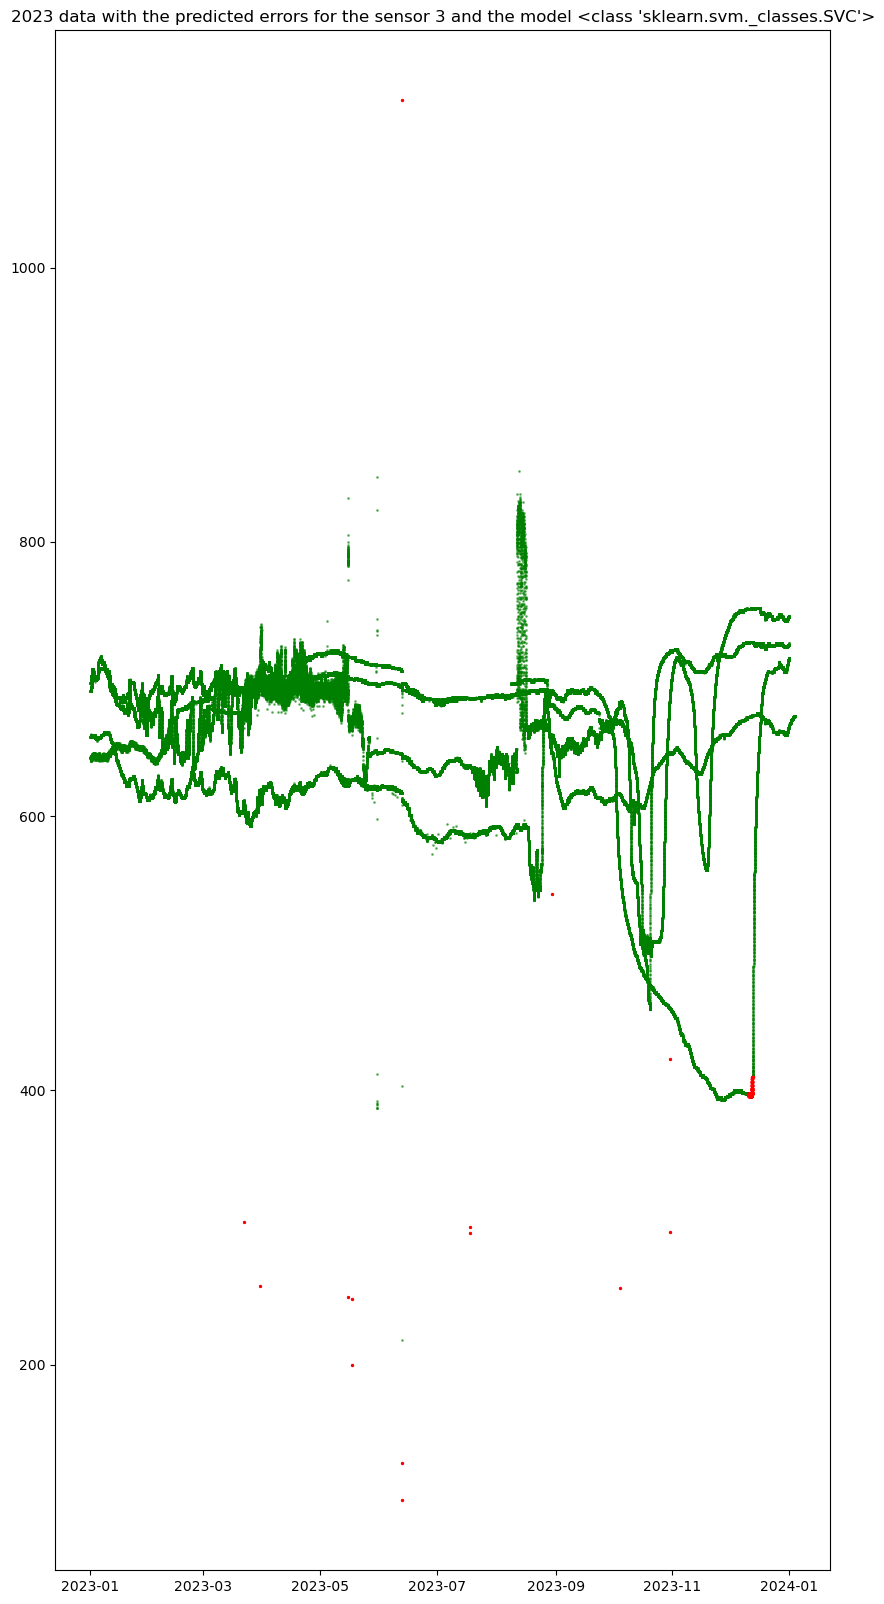

accuracy of the <class 'sklearn.svm._classes.SVC'> on the sensor 3 is 0.9368938121851582


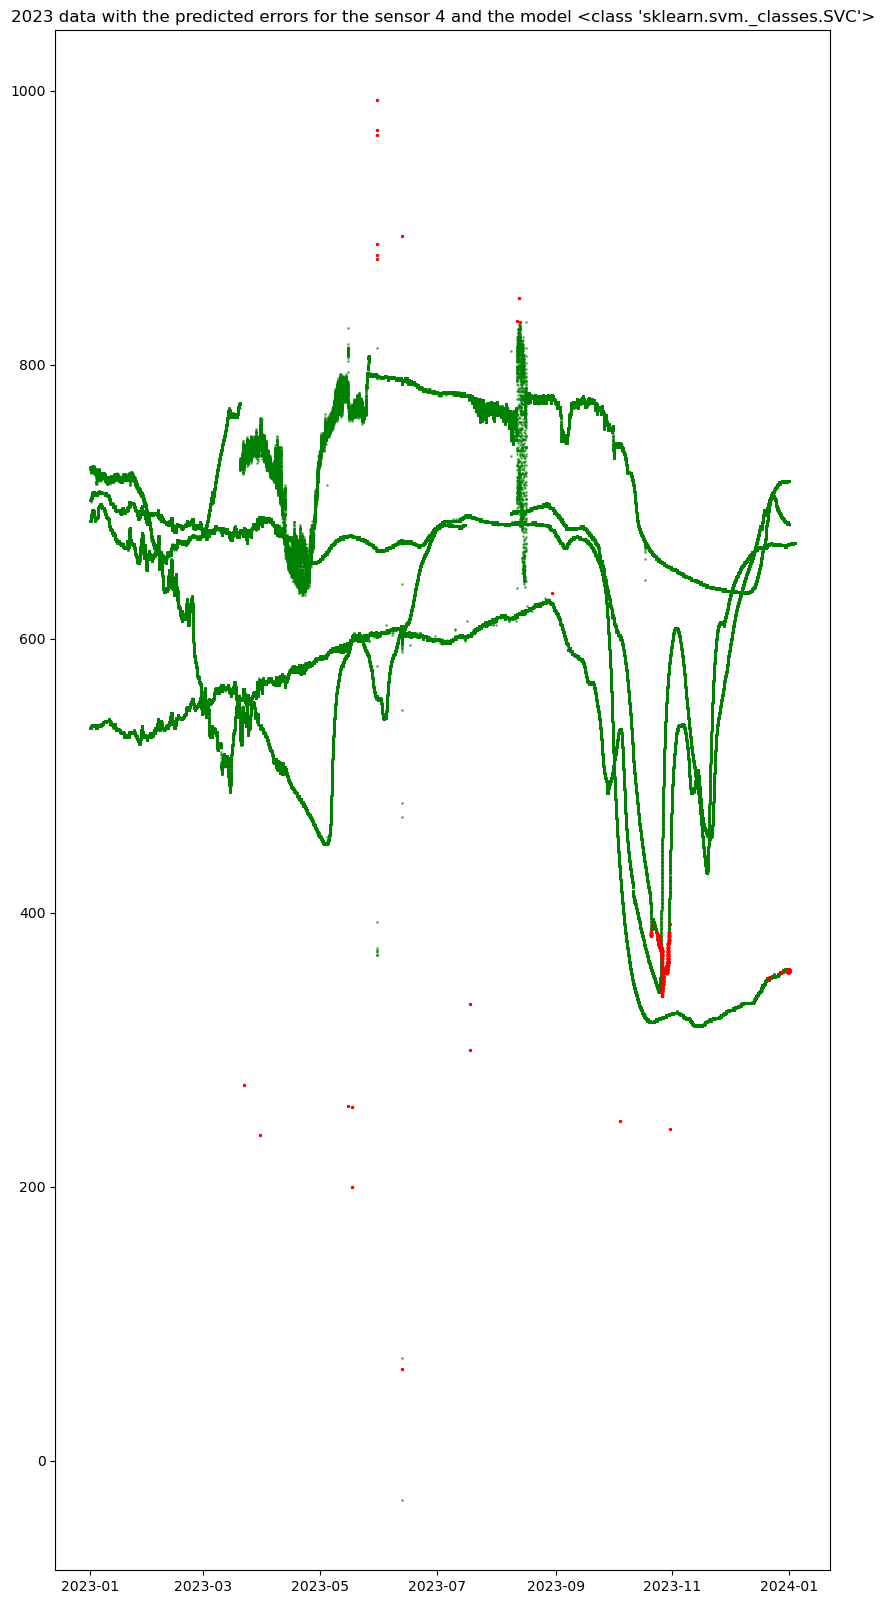

accuracy of the <class 'sklearn.svm._classes.SVC'> on the sensor 4 is 0.9581213503420967


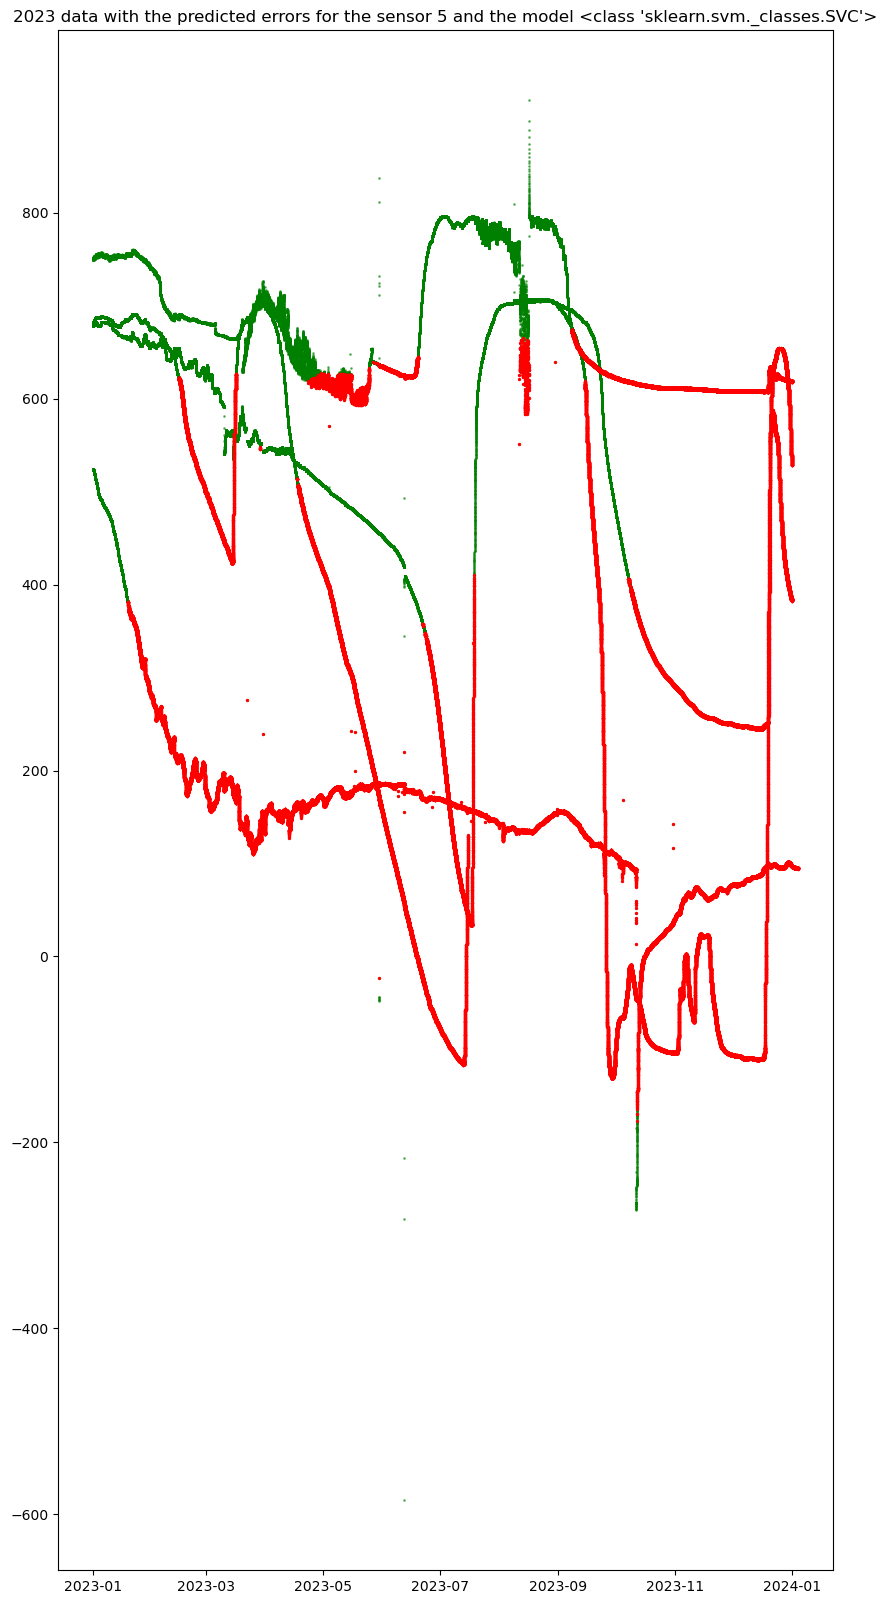

accuracy of the <class 'sklearn.svm._classes.SVC'> on the sensor 5 is 0.9624570812761585


In [15]:
keywords = [{"random_state": 0, "max_depth": 5, "n_estimators": 20}, {}, {}, {}, {}]

# Additional models - NuSVC, LinearSVC
# Additional target variables - "total_error_flag(" + str(i) + ")" , "Redox_error_flag(" + str(i) + ")"  "combined_error_flag(" + str(i) + ")"

models = [RandomForestClassifier, LogisticRegression, GaussianNB, KNeighborsClassifier, SVC]

models_with_arguments = zip(models, keywords)

total_results = pd.DataFrame()

for model, keywords in models_with_arguments:
    results = dict()
    results["model"] = str(model)
    
    for i in np.arange(1,6):

        features = df2022[level_features_dict[i]]
        labels = df2022[ "combined_error_flag(" + str(i) + ")"]
        
        if model == SVC | model == KNeighborsClassifier:
            scaler = StandardScaler()
            features = scaler.fit(features).transform(features)
        

        acc, Regressor = fit_predict(model, features, labels, **keywords)
        
        predicted2023 = Regressor.predict(df2023[level_features_dict[i]])
        
        fig = plt.figure(figsize = (10,20))
        ax = plt.gca()
        
        ax.scatter(x = df2023["TIMESTAMP"], y = df2023["Redox_Avg("+ str(i)+ ")"], color = "green", alpha = 0.5, s = 1)
        ax.scatter(x = df2023.loc[predicted2023, ["TIMESTAMP"]], y = df2023.loc[predicted2023, ["Redox_Avg("+ str(i)+ ")"]], color = "red", s = 2)
        ax.set_title(f"2023 data with the predicted errors for the sensor {i} and the model {model}")
        
        plt.show()
        
        print(f"accuracy of the {str(model)} on the sensor {i} is {acc}")
        results["sensor("+ str(i)+ ")"] = acc
    
    total_results = pd.concat([total_results, pd.DataFrame(results, index = [i])])


In [9]:
df2023.columns

Index(['TIMESTAMP', 'Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)',
       'Redox_Avg(4)', 'Redox_Avg(5)', 'Temp_T12_Avg(1)', 'EC_Avg(1)',
       'Temp_T12_Avg(2)', 'EC_Avg(2)', 'Temp_T12_Avg(3)', 'EC_Avg(3)',
       'Temp_T12_Avg(4)', 'EC_Avg(4)', 'Temp_T12_Avg(5)', 'EC_Avg(5)',
       'Matric_potential_Avg(1)', 'Matric_potential_Avg(2)',
       'Matric_potential_Avg(3)', 'Matric_potential_Avg(4)',
       'Matric_potential_Avg(5)', 'Water_level_Avg', 'Temp_ottpls_Avg',
       'BatterymV_Min', 'WC1', 'WC2', 'WC3', 'WC4', 'WC5', 'pit_number',
       'log_redox(1)', 'log_redox(2)', 'log_redox(3)', 'log_redox(4)',
       'log_redox(5)', 'Redox_error_flag(1)', 'Redox_error_flag(2)',
       'Redox_error_flag(3)', 'Redox_error_flag(4)', 'Redox_error_flag(5)',
       'Redox_error_flag', 'Redox_error_flag_available', 'total_error_flag(1)',
       'total_error_flag(2)', 'total_error_flag(3)', 'total_error_flag(4)',
       'total_error_flag(5)', 'combined_error_flag(1)',
       'combined_error_f

### Linear Discriminative Analysis / Quadratic Discriminative Analysis

In [ ]:
LDAresults = dict()

for i in np.arange(1,6):
    # scaler = StandardScaler()
    # features = df2022[level_features_dict[i]]
    
    features = scaler.fit(features).transform(features)
    labels = df2022[ "combined_error_flag(" + str(i) + ")"]

    acc, Regressor = fit_predict(LDA, features, labels, **{})

    print(f"accuracy of SVC on the sensor {i} is {acc}")
    LDAresults["Sensor "+ str(i)] = acc
    
    predicted2023 = Regressor.predict(df2023[level_features_dict[i]])
    
    fig = plt.figure(figsize = (10,20))
    ax = plt.gca()
    
    ax.scatter(x = df2023["TIMESTAMP"], y = df2023["Redox_Avg("+ str(i)+ ")"], color = "green", alpha = 0.5, s = 1)
    ax.scatter(x = df2023.loc[predicted2023, ["TIMESTAMP"]], y = df2023.loc[predicted2023, ["Redox_Avg("+ str(i)+ ")"]], color = "red", s = 2)
    ax.set_title(f"2023 data with the predicted errors for the sensor {i} and the model {LDA}")
    
    plt.show()
    
print(LDAresults)

In [ ]:
QDAresults = dict()

for i in np.arange(1,6):
    # scaler = StandardScaler()
    # features = df2022[level_features_dict[i]]
    
    features = scaler.fit(features).transform(features)
    labels = df2022[ "combined_error_flag(" + str(i) + ")"]

    acc, Regressor = fit_predict(QDA, features, labels, **{})

    print(f"accuracy of SVC on the sensor {i} is {acc}")
    QDAresults["Sensor "+ str(i)] = acc
    
    predicted2023 = Regressor.predict(df2023[level_features_dict[i]])
    
    fig = plt.figure(figsize = (10,20))
    ax = plt.gca()
    
    ax.scatter(x = df2023["TIMESTAMP"], y = df2023["Redox_Avg("+ str(i)+ ")"], color = "green", alpha = 0.5, s = 1)
    ax.scatter(x = df2023.loc[predicted2023, ["TIMESTAMP"]], y = df2023.loc[predicted2023, ["Redox_Avg("+ str(i)+ ")"]], color = "red", s = 2)
    ax.set_title(f"2023 data with the predicted errors for the sensor {i} and the model {QDA}")
    
    plt.show()
    
print(QDAresults)

### OneClassSVM for outlier detection - questions : description of the algorithm, if it's trained on the clean data or on the data with "polluted data"

In [16]:
for i in np.arange(1,6):

    if i == 1:
        
        # here is the data only for pit number 3 
        
        features = df2022[df2022["pit_number"]==3][level_features_dict[i]]
        labels = df2022[df2022["pit_number"]==3][ "combined_error_flag(" + str(i) + ")"]
        scaler = StandardScaler()
        features = scaler.fit(features).transform(features)
        outlier_detector = OneClassSVM()
        print(np.unique(outlier_detector.fit(features).predict(features), return_counts = True))
        
        # predictions = True if outlier_detector.fit(features).predict(features) == -1 else False
        # acc = 1/len(predictions) * sum(predictions == labels)
        # print(f"the accuracy of OneClassSVM on the sensor {i} data is {acc}")
        
        
            

(array([-1,  1]), array([13539, 13544]))


### Verify if the data are coming from the normal distribution (univariate, multivariate) 
b) can be checked as well for the combined data and data separated to erroneous and normal observations

### Gaussian mixture - Check what the mixture of Gaussian will get in terms how it will distribute the correct and erroneous data between classes 

### VAR models - using the past values of the variables for the prediction of the future 

### Regressing the measurements on other variables and / or past values and check if it's possible to predict the erroneous data by the difference between predicted and actual values

### Wave transform / Fourier transform explorations 

### Lower dimensional representation of the data 

### GridSearch for Random Forest Classifier

In [ ]:
param_grid = {"n_estimators" : [200, 300, 400, 500], "max_features" : ["sqrt", "log2"], "max_depth" : [4,5,6,7,8], "criterion" : ["gini", "entropy"]}

rf_grid = MS.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv = 5)

df2 = df[['Redox_Avg(1)', 'CCVWC_Avg(1)', 'Temp_T12_Avg(1)', 'EC_Avg(1)', 'Matric_potential_Avg(1)', 'Temp_T21_Avg(1)', 'Water_level_Avg', 'Temp_ottpls_Avg', 'shf_plate_Avg', 'shf_multiplier', 
            'shf_htr_resstnc', 'shfp_wrnng_flg', 'btt_wrnng_flg', 'BatterymV_Min', 'BattV_Min', 'PTemp_C_Avg', 'WC1', 'Redox_Avg(1)_sigma_b', 'Redox_Avg(1)_sigma_f', 'Redox_error_flag(1)']].dropna()

features = df2[df2.columns[df2.columns != 'Redox_error_flag(1)']]
labels = df2['Redox_error_flag(1)']

rf_grid.fit(features, labels)

print(rf_grid.best_params_)

print(f"the best score on the search space is = {rf_grid.best_score_}") 

In [295]:
df2 = df[['Redox_Avg(1)', 'CCVWC_Avg(1)', 'Temp_T12_Avg(1)', 'EC_Avg(1)', 'Matric_potential_Avg(1)', 'Temp_T21_Avg(1)', 'Water_level_Avg', 'Temp_ottpls_Avg', 'shf_plate_Avg', 'shf_multiplier', 
            'shf_htr_resstnc', 'shfp_wrnng_flg', 'btt_wrnng_flg', 'BatterymV_Min', 'BattV_Min', 'PTemp_C_Avg', 'WC1', 'Redox_error_flag(1)']].dropna()

features = df2[df2.columns[df2.columns != 'Redox_error_flag(1)']]
labels = df2['Redox_error_flag(1)']

acc, Regressor = fit_predict(features, labels)

print(f"accuracy of the random forest prediction is {acc}")
print(pd.DataFrame([a for a in zip(Regressor.feature_names_in_, Regressor.feature_importances_)]))

accuracy of the random forest prediction is 0.9999244256348246
                          0         1
0              Redox_Avg(1)  0.182480
1              CCVWC_Avg(1)  0.134161
2           Temp_T12_Avg(1)  0.025112
3                 EC_Avg(1)  0.105118
4   Matric_potential_Avg(1)  0.034179
5           Temp_T21_Avg(1)  0.005820
6           Water_level_Avg  0.081617
7           Temp_ottpls_Avg  0.085101
8             shf_plate_Avg  0.015538
9            shf_multiplier  0.027738
10          shf_htr_resstnc  0.053695
11           shfp_wrnng_flg  0.012122
12            btt_wrnng_flg  0.000000
13            BatterymV_Min  0.025532
14                BattV_Min  0.072106
15              PTemp_C_Avg  0.011279
16                      WC1  0.128403


In [ ]:
df2 = df[['Redox_Avg(1)', 'CCVWC_Avg(1)', 'Temp_T12_Avg(1)', 'EC_Avg(1)', 'Matric_potential_Avg(1)', 'Temp_T21_Avg(1)', 'Water_level_Avg', 'Temp_ottpls_Avg', 'shf_plate_Avg', 'shf_multiplier', 
            'shf_htr_resstnc', 'shfp_wrnng_flg', 'btt_wrnng_flg', 'BatterymV_Min', 'BattV_Min', 'PTemp_C_Avg', 'WC1', 'Redox_Avg(1)_sigma_b', 'Redox_Avg(1)_sigma_f', 'Redox_error_flag(1)']].dropna()

features = df2[df2.columns[df2.columns != 'Redox_error_flag(1)']]
labels = df2['Redox_error_flag(1)']

acc, Regressor = fit_predict(features, labels)

print(f"accuracy of the random forest prediction is {acc}")

print(pd.DataFrame([a for a in zip(Regressor.feature_names_in_, Regressor.feature_importances_)]))

In [ ]:
# df2 = df[['Redox_Avg(1)', 'CCVWC_Avg(1)', 'Temp_T12_Avg(1)', 'EC_Avg(1)', 'Matric_potential_Avg(1)', 'Temp_T21_Avg(1)', 'Water_level_Avg', 'Temp_ottpls_Avg', 'shf_plate_Avg', 'shf_multiplier', 
#            'shf_htr_resstnc', 'shfp_wrnng_flg', 'btt_wrnng_flg', 'BatterymV_Min', 'BattV_Min', 'PTemp_C_Avg', 'WC1', 'Redox_error_flag(1)']].dropna()

df2 = df[['Redox_Avg(1)', 'EC_Avg(1)', 'Matric_potential_Avg(1)', 'Temp_T21_Avg(1)', 'Water_level_Avg', 'Temp_ottpls_Avg', 'BatterymV_Min', 'BattV_Min', 'WC1', 'Redox_error_flag(1)']].dropna()

features = df2[df2.columns[df2.columns != 'Redox_error_flag(1)']]
labels = df2['Redox_error_flag(1)']

acc, Regressor = fit_predict(features, labels)

print(f"accuracy of the random forest prediction is {acc}")
print(pd.DataFrame([a for a in zip(Regressor.feature_names_in_, Regressor.feature_importances_)]))